# CARDIO DISEASES PREDICTION

Cadio Catch is a company specializing in detecting early-stage heart diseases. The company offers an early diagnosis of cardiovascular diseases for a certain price. The diagnosis is done manually and the accuracy is currently between 55% and 60%, due to the complex diagnosis and team limitations.
The objective is to biuld a better predictive model to classify a patient's risk of having a cardiovascular disorder.

Some considerations:

- Each diagnosis costs at least 1000,00.
- The price will vary according to the precision: customer pays 500,00 for every 5% increase in model accuracy.
- If the diagnostic precision is 50% or less, the customer does not pay for the service.


## INDEX

- **0.0. DATA COLLECTION**
- **1.0. DATA DESCRIPTION**
- **2.0. FEATURE ENGINEERING**
- **3.0. DATA FILTERING**
- **4.0. EXPLORATORY DATA ANALYSIS**
- **5.0. DATA PREPARATION**
- **6.0. FEATURE SELECTION**
- **7.0. MACHINE LEARNING MODELLING**
- **8.0. HYPERPARAMETER FINE TUNNING**
- **9.0. BUSINESS PERFORMANCE**
- **10.0. DEPLOY MODEL TO PRODUCTION**



# 0.0. DATA COLLECTION
## 0.1. Imports

In [1]:
#data manipulation
import pandas                as pd
import numpy                 as np

#data visualization
import seaborn               as sns
import matplotlib.pyplot     as plt
import sklearn.metrics       as mt

#scikit-learn
from sklearn.preprocessing   import RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score,cross_val_predict,RandomizedSearchCV
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score, classification_report,cohen_kappa_score,recall_score,f1_score,roc_auc_score, plot_precision_recall_curve, precision_score,roc_curve,confusion_matrix,ConfusionMatrixDisplay
from sklearn.pipeline        import Pipeline
from sklearn.neighbors       import KNeighborsClassifier
from sklearn                 import svm

#balanced imports
from imblearn import under_sampling as us
from imblearn import over_sampling as oversamp
from imblearn import combine as c

#auxiliar packages
from IPython.display         import Image
from IPython.core.display    import HTML
from scipy                   import stats
from math                    import sqrt
from tabulate                import tabulate
from boruta                  import BorutaPy
import xgboost               as xgb
from lightgbm                import LGBMClassifier
import random
import pickle

import warnings
warnings.filterwarnings('ignore')

## 0.2. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    sns.set()
    
# point biserial correlation coefficient heatmap function
def point_bi(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name),fontsize = 25);

In [3]:
#setting the function
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.3. Loading Data


Types of variables:
- Objective: factual information;
- Examination: results of medical examination;
- Subjective: information given by the patient.

![image](CardioVariables.png "Title")

In [4]:
#loading dataset as a dataframe
df_raw = pd.read_csv("cardio_train.csv", sep = ';')
df_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# 1.0. DATA DESCRIPTION

- Data Dimension
- Checking Missings Data
- Data Types
- Change Types
- Descriptive Statistical

In [5]:
# Copy of the original data
df1 = df_raw.copy()

In [6]:
# Column names
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

## 1.1. Data Dimension

In [7]:
# number of rows and columns in the dataframe
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 70000
Number of columns: 13


## 1.2. Checking Missing Data

In [8]:
#checking missing data
df1.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.3. Data Types

In [9]:
# checking the data type of each variable
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.4. Change Types

In [10]:
#changing id type to object
df1['id'] = df1['id'].astype("object")

#creating a new column: coverting age to years format
df1['age_year'] = df1['age'].apply(lambda x: x/365)

#age_year convert
df1['age_year'] = df1['age_year'].astype(int)

In [11]:
df1.dtypes

id              object
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
age_year         int32
dtype: object

## 1.5. Descriptive Statistical

### 1.5.1. Numerical Attributes

- Central tendency
    - average 
    - median
 .
- Dispersion 
  - std
  - min 
  - max 
  - range
  - skew
  - kurtosis

In [12]:
#selecting numerical data
num_attributes = df1.select_dtypes(exclude = ['object'])

#dropping the binary features
num_attributes.drop(columns = ['gluc','smoke','alco','active','cardio','cholesterol'], axis = 1, inplace = True)

In [13]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dipersion - std,min,max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concat as a unique dataframe
desc_stats = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

desc_stats.columns = columns
desc_stats

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,10798.0,23713.0,12915.0,19468.865814,19703.0,2467.234044,-0.307055,-0.823447
1,gender,1.0,2.0,1.0,1.349571,1.0,0.476835,0.630960,-1.601935
2,height,55.0,250.0,195.0,164.359229,165.0,8.210068,-0.642187,7.943653
3,weight,10.0,200.0,190.0,74.205690,72.0,14.395654,1.012070,2.586825
4,ap_hi,-150.0,16020.0,16170.0,128.817286,120.0,154.010319,85.296214,7580.074738
5,ap_lo,-70.0,11000.0,11070.0,96.630414,80.0,188.471184,32.114083,1425.914585
6,age_year,29.0,64.0,35.0,52.840671,53.0,6.766725,-0.305744,-0.818981


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'height'}>],
       [<AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'ap_hi'}>,
        <AxesSubplot:title={'center':'ap_lo'}>],
       [<AxesSubplot:title={'center':'age_year'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

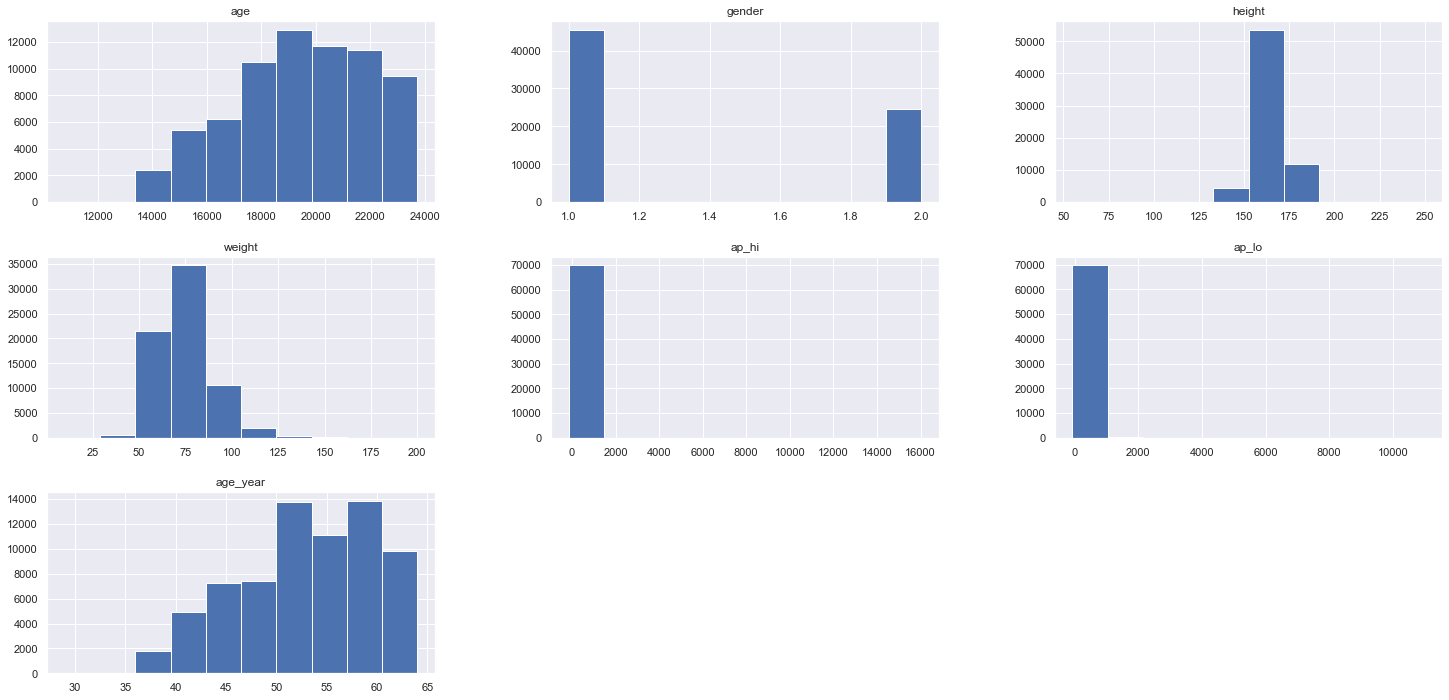

In [14]:
#plot numerical variables
num_attributes.hist()

### 1.5.2. Binary and Ordinal Attributes

<AxesSubplot:xlabel='cholesterol', ylabel='count'>

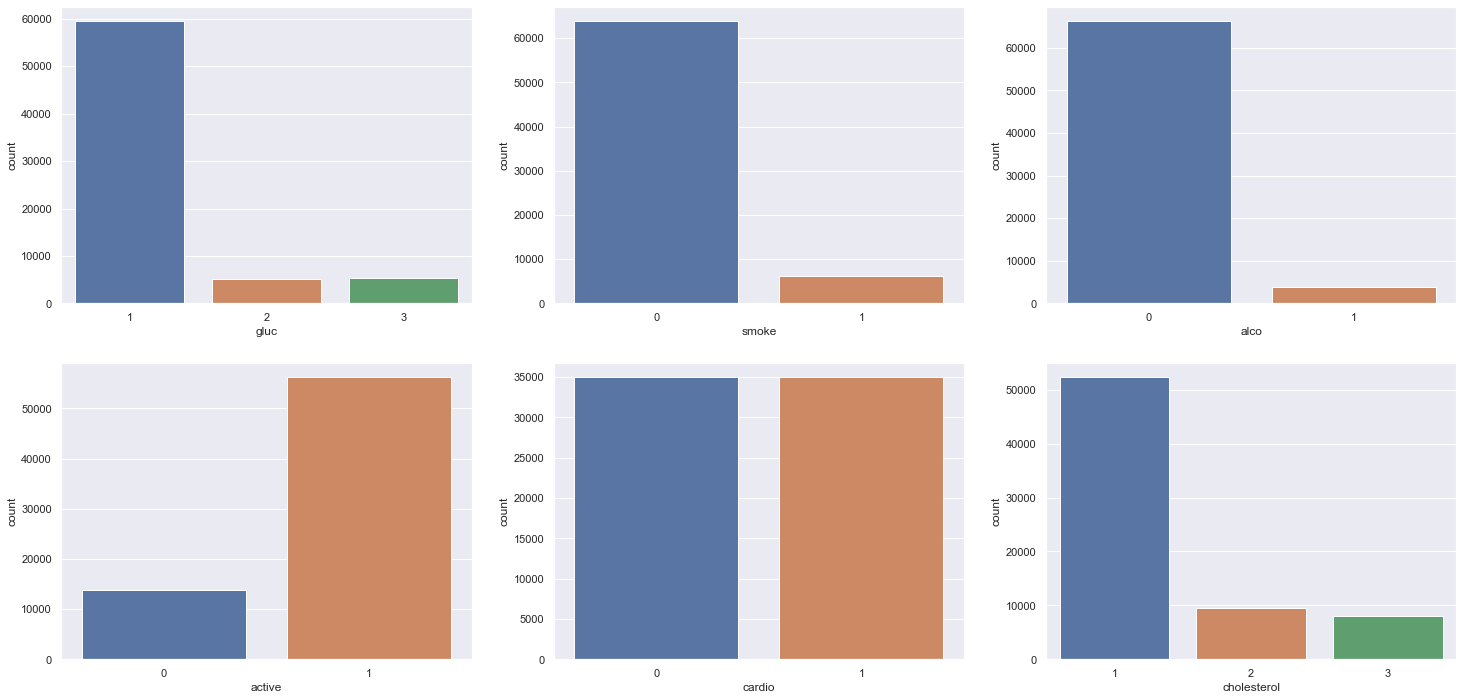

In [15]:
#define binary attributes
binary_attributes = df1[['gluc','smoke','alco','active','cardio','cholesterol']]

#plotting each feature
plt.subplot(2,3,1)
sns.countplot(binary_attributes['gluc'])

plt.subplot(2,3,2)
sns.countplot(binary_attributes['smoke'])

plt.subplot(2,3,3)
sns.countplot(binary_attributes['alco'])

plt.subplot(2,3,4)
sns.countplot(binary_attributes['active'])

plt.subplot(2,3,5)
sns.countplot(binary_attributes['cardio'])

plt.subplot(2,3,6)
sns.countplot(binary_attributes['cholesterol'])

# 2.0. FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## 2.1 Hypotheses - Mind Map

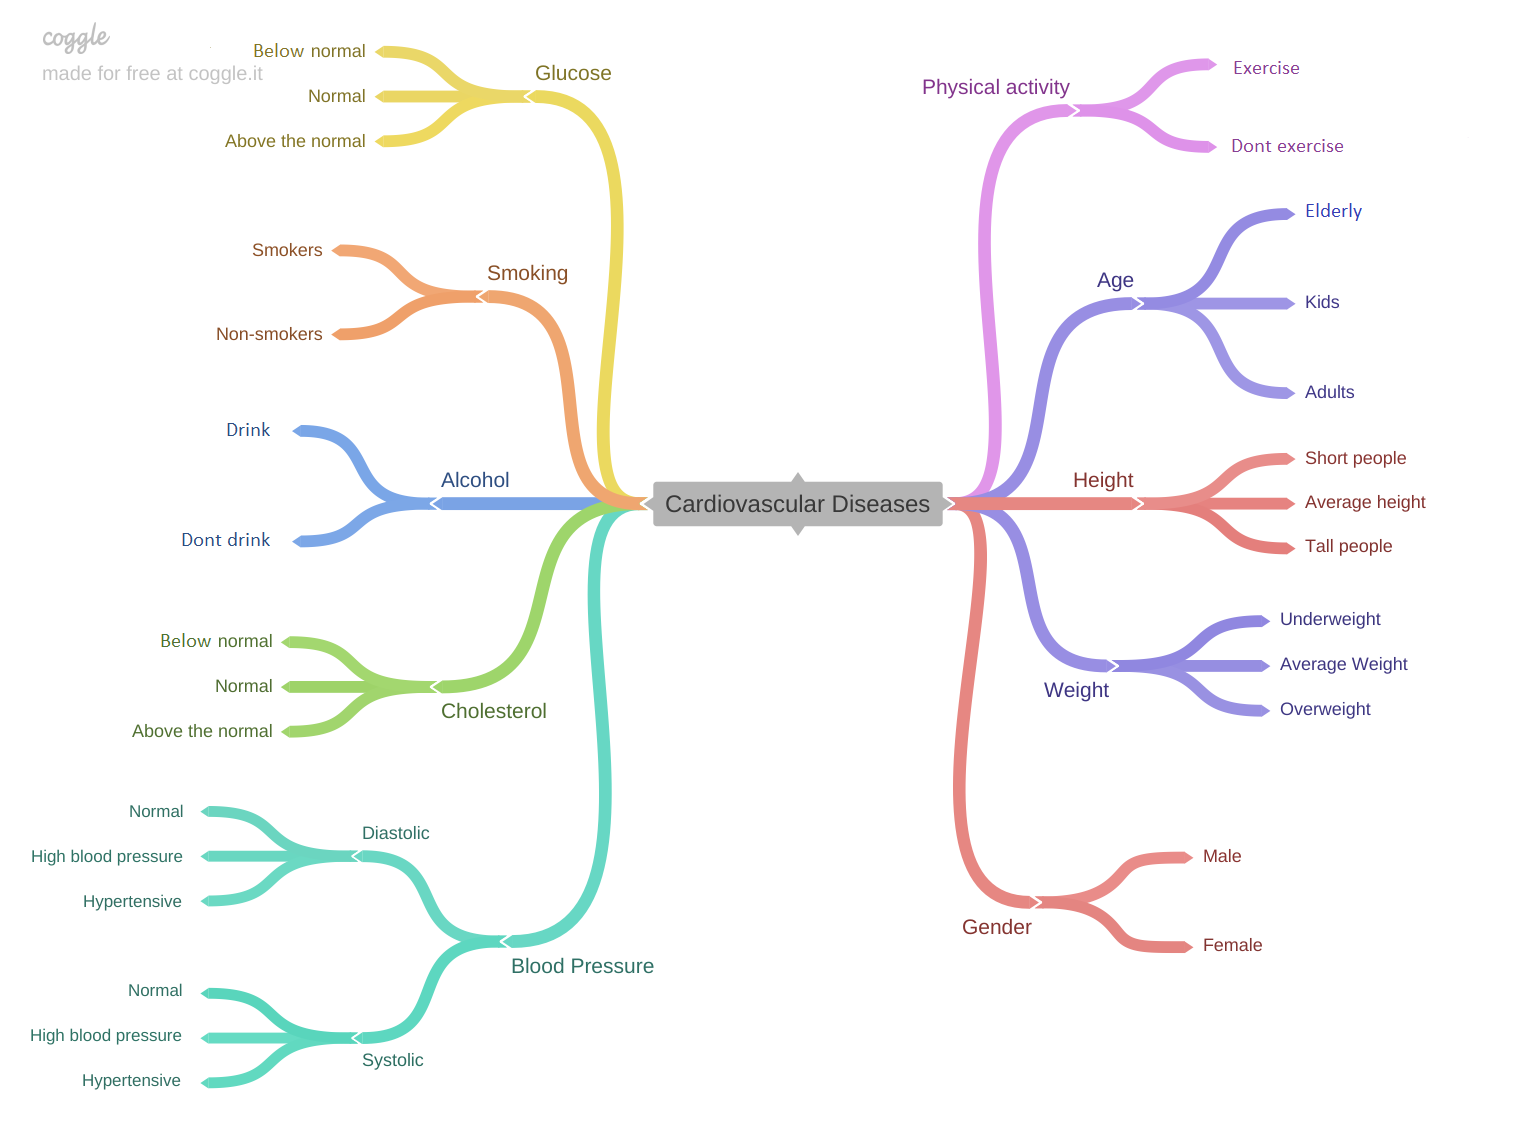

In [17]:
Image("CardioMindMap.png")

## 2.2. List of Hypotheses

**1.** **AGE**- Cardiovascular diseases are more common in older people
    
**2.** **GENDER** - Gender does not affect the presence of cardiovascular diseases.
    
**3.** **BLOOD PRESSURE**- People with higher diastolic and systolic blood pressure are more likely to have heart diseases.
    
**4.** **SMOKING** - There are more cases of cardiovascular diseases among people who smoke.
    
**5.** **ALCOHOL INTAKE** - There are more cases of cardiovascular diseases among people who drink alcohol.
    
**6.** **WEIGHT** - Obese and overweight persons are more likely to have cardiovascular diseases.

**7.** **PHYSICAL ACTIVITY**- There are fewer cases of cardiovascular diseases in people who exercise regularly.
    
**8.** **GLUCOSE**- People with high glucose rates are more likely to have heart diseases.
    
**9.** **CHOLESTEROL**- There are more cases of cardiovascular diseases among people with high cholesterol levels.
   
**10.** **HEIGHT** - Height does not affect the presence of cardiovascular diseases.

## 2.3. Feature Engineering

### 2.3.1. Blood Pressure

   Transforming blood pressure variable in categories:
   - Normal: Systolic pressure less than 120 and diastolic pressure less than 80
   - Elevated: Systolic pressure between 120-129 and diastolic pressure less than 80
   - High Blood Pressure: Systolic pressure between 130-139 and diastolic pressure between 80-89
   - Hypertension: Systolic pressure above the 140 and diastolic pressure equal or above the 90
   
   Font: https://www.forbes.com/health/healthy-aging/normal-blood-pressure-chart-by-age/

In [18]:
#categories
df2['blood_pressure'] = df2.apply(lambda x:'normal' if (x['ap_hi'] <= 120) & (x['ap_lo'] <= 80)
                                 else 'elevated' if (x['ap_hi'] > 120 and x['ap_hi'] <= 129) & (x['ap_lo'] <= 80)
                                 else "high" if (x['ap_hi'] >= 130 and x['ap_hi'] <= 139) & (x['ap_lo'] <= 90)
                                 else 'hypertension', axis = 1)

### 2.3.2. Weight

Transforming weight variable in categories:
- Healthy Weight: BMI between	18.5 and 25
- Overweight: BMI between 25 and 30
- Obese: BMI between 30 and 40
- Severely Obese: BMI higher than 40.00

Font: https://www.worldobesity.org/about/about-obesity/obesity-classification

**m² = cm²/10000**

In [19]:
#bmi calculation
df2['bmi'] = round((df2['weight']/((df2['height'] * df2['height'])/10000)),2)

In [20]:
#creating status_bmi column
df2['status_bmi'] = df2['bmi'].apply(lambda x: 'underweight' if x <= 18.5
                                          else 'normal' if (x > 18.5) & (x < 24.9) 
                                          else 'overweight' if (x >= 25) & (x <= 29.9)
                                          else 'obese' if (x >= 30) & (x<= 34.9) 
                                          else 'severely_obese')

### 2.3.3 Age

In [21]:
#creating age categories
df2['age_range'] = df2['age_year'].apply(lambda x:"0-40" if x <= 40
                                             else "40-50" if (x>40) & (x<=50)
                                             else "50-60" if (x>50) & (x<=60)
                                             else "60-70" if (x>60) & (x<=70)
                                             else ">65")

In [22]:
df2.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year,blood_pressure,bmi,status_bmi,age_range
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,normal,21.97,normal,40-50
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,hypertension,34.93,severely_obese,50-60
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,high,23.51,normal,50-60
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,hypertension,28.71,overweight,40-50
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,normal,23.01,normal,40-50
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,60,normal,29.38,overweight,50-60
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,60,high,37.73,severely_obese,50-60
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1,61,high,29.98,severely_obese,60-70
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0,48,normal,28.44,overweight,40-50
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0,54,normal,25.28,overweight,50-60


In [23]:
df2.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'age_year',
       'blood_pressure', 'bmi', 'status_bmi', 'age_range'],
      dtype='object')

# 3.0. DATA FILTERING

In [24]:
df3=df2.copy()

## 3.1. Filtering Columns

In [25]:
df3=df3.drop("id", axis=1)

## 3.2. Filtering Rows

### 3.2.1 Systolic Blood Pressure

Text(0.5, 1.0, 'With Filter')

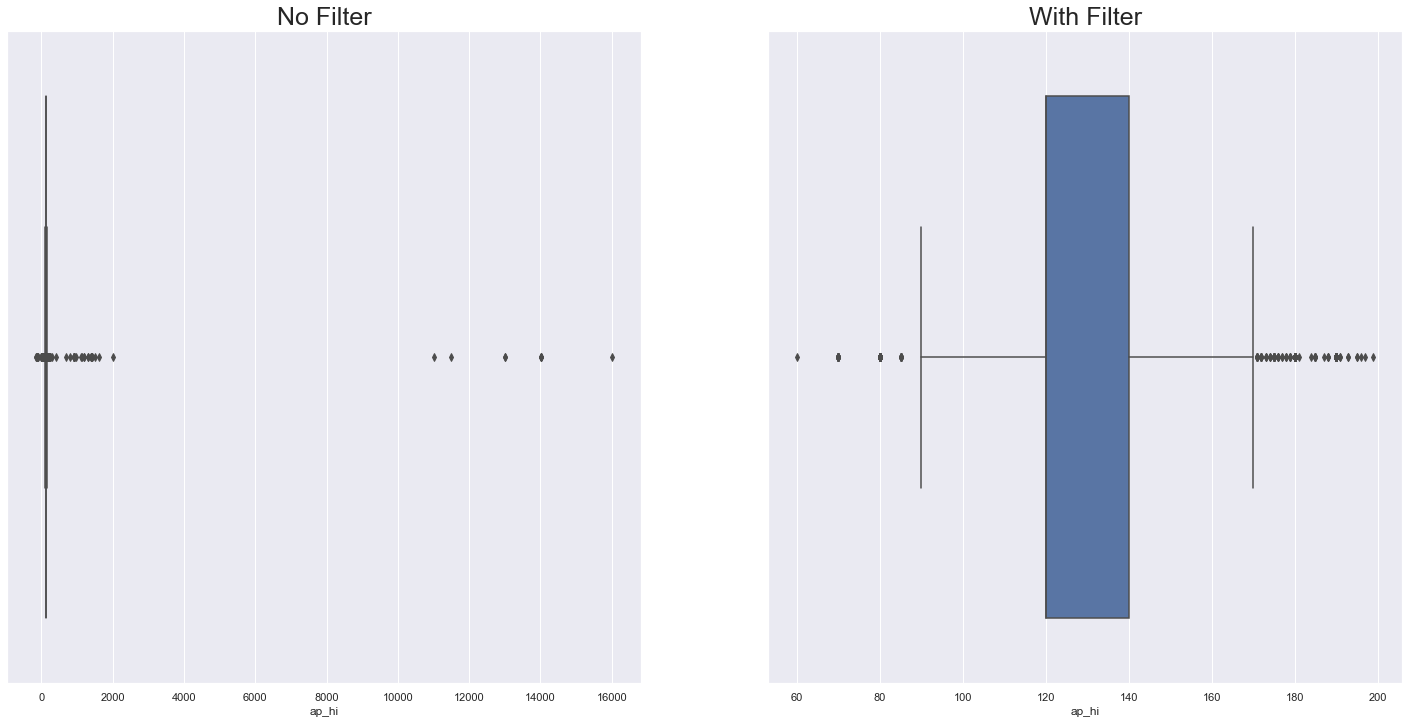

In [26]:
#original data boxplot
plt.subplot(1,2,1)
sns.boxplot(df3['ap_hi'])
plt.title("No Filter", fontsize = 25)

#filtering values 
aux1 = df3[(df3['ap_hi'] < 200) & (df3['ap_hi'] > 50)]

#filtered data boxplot
plt.subplot(1,2,2)
sns.boxplot(aux1['ap_hi'])
plt.title("With Filter", fontsize = 25)

### 3.2.2 Diastolic Blood Pressure

Text(0.5, 1.0, 'With Filter')

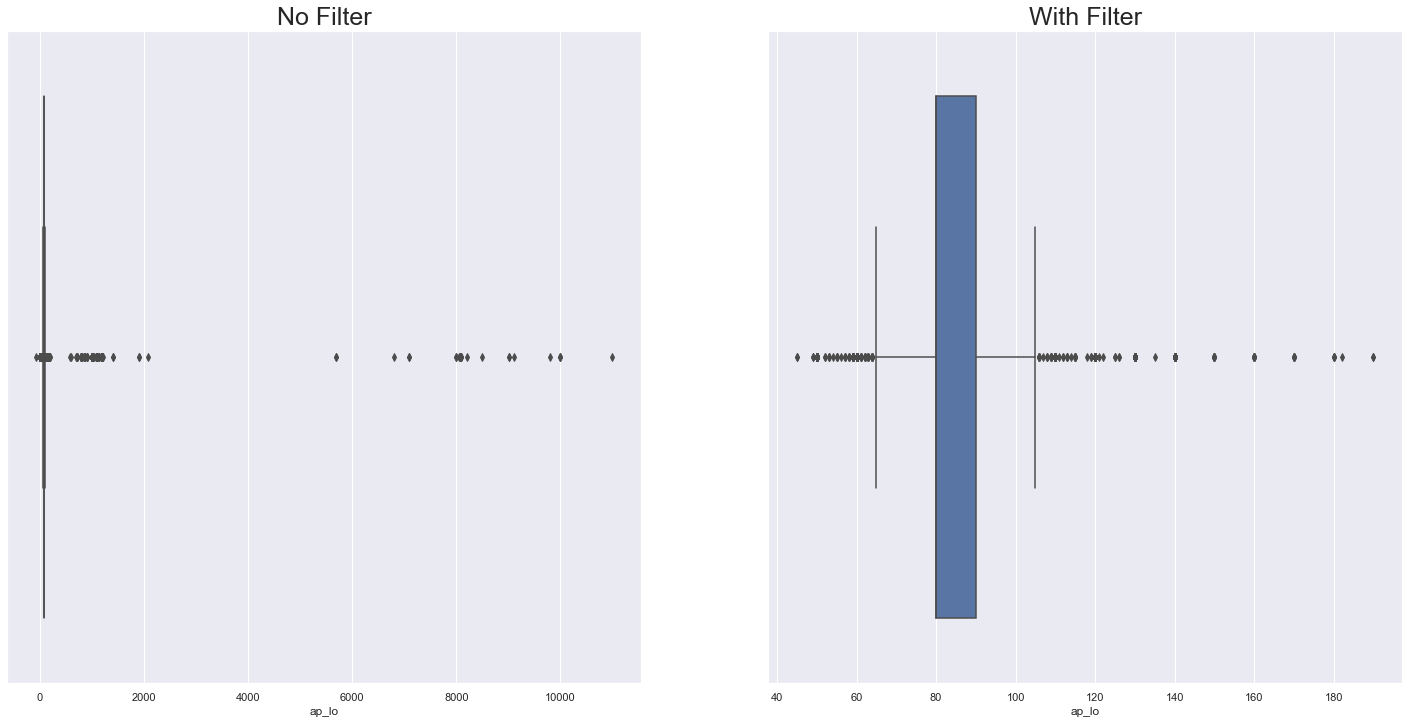

In [27]:
#original data boxplot
plt.subplot(1,2,1)
sns.boxplot(df3['ap_lo'])
plt.title("No Filter", fontsize = 25)

#filtering values 
aux2 = df3[(df3['ap_lo'] < 200)  & (df3['ap_lo'] > 40)]

#filtered data boxplot
plt.subplot(1,2,2)
sns.boxplot(aux2['ap_lo'])
plt.title("With Filter", fontsize = 25)

### 3.2.3 Height 

<AxesSubplot:xlabel='height', ylabel='Density'>

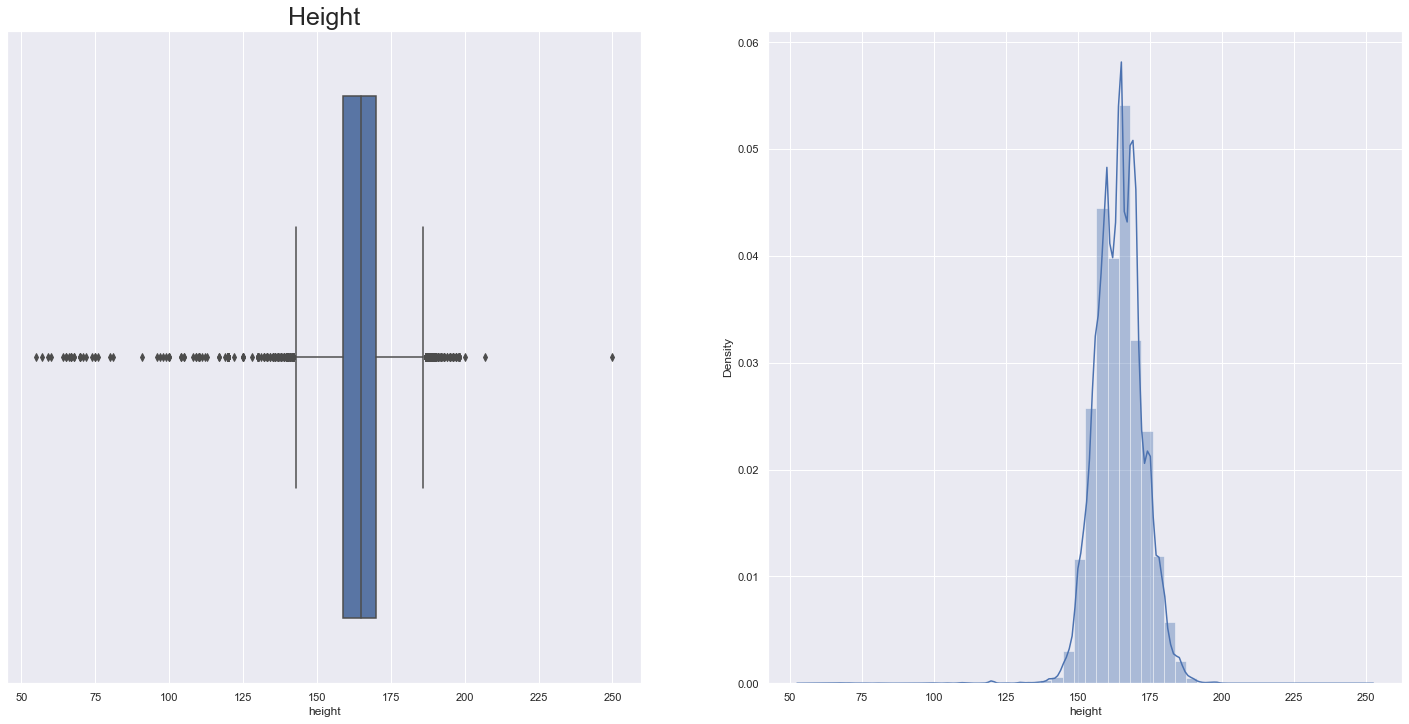

In [28]:
#original data boxplot
plt.subplot(1,2,1)
sns.boxplot(df3['height'])
plt.title("Height", fontsize = 25)

#distribution plot
plt.subplot(1,2,2)
sns.distplot(df3['height'])

<AxesSubplot:xlabel='height', ylabel='Density'>

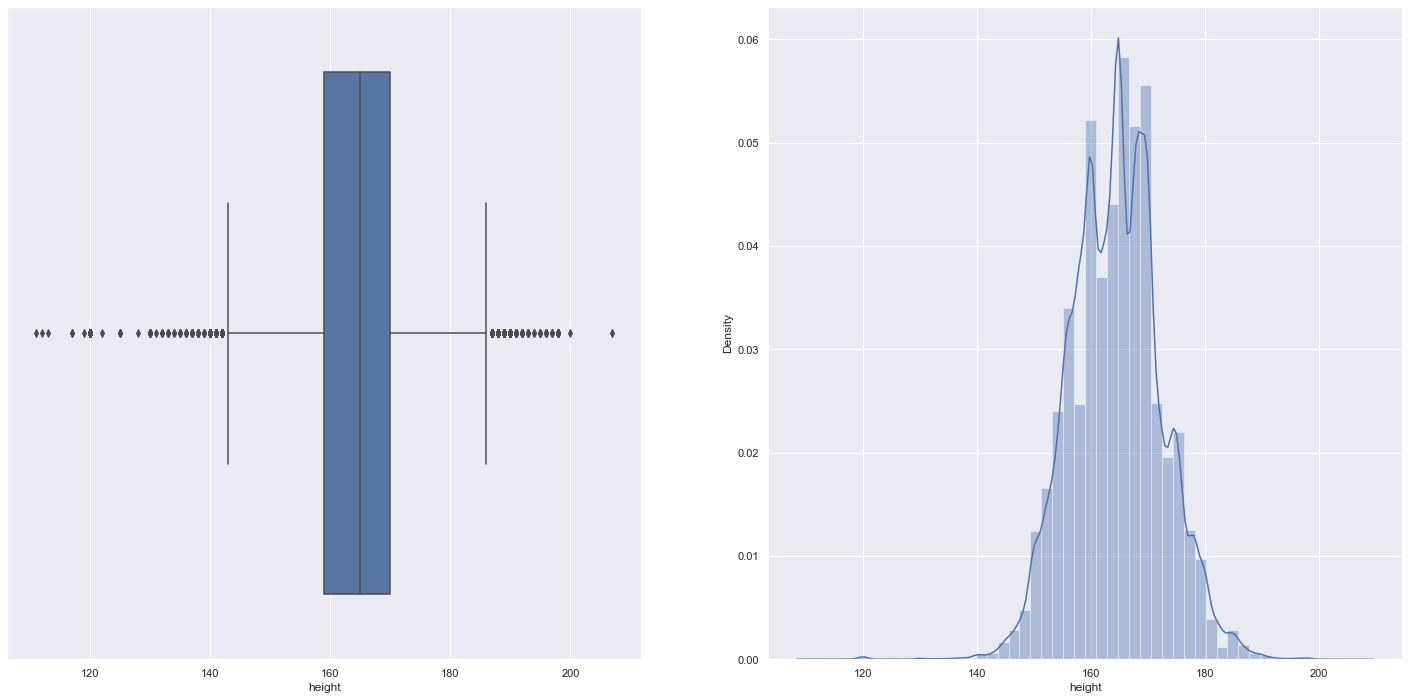

In [29]:
#filtering values
aux3= df3[(df3['height'] > 110) & (df3['height'] < 225)]

#filtered data boxplot
plt.subplot(1,2,1)
sns.boxplot(aux3['height'])

#distribuition plot
plt.subplot(1,2,2)
sns.distplot(aux3['height'])

### 3.2.4. Weight

<AxesSubplot:xlabel='weight'>

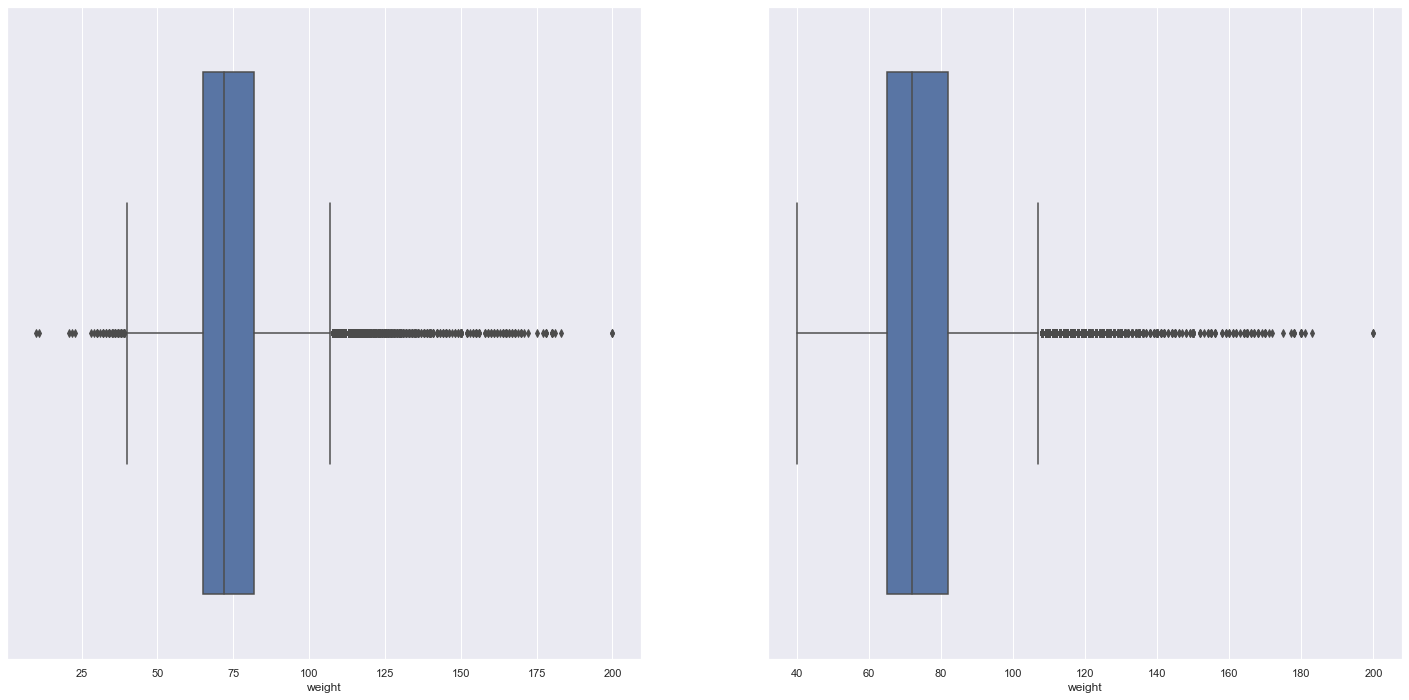

In [30]:
#original data boxplot
plt.subplot(1,2,1)
sns.boxplot(df3['weight'])

#removing inconsistent values
aux4 = df3[~(df3['weight'] < 40)]

#filtered data boxplot
plt.subplot(1,2,2)
sns.boxplot(aux4['weight'])

### 3.2.5 Removing Outliers

In [31]:
#removing outliers
df3 = df3[(df3['ap_hi'] < 200) & (df3['ap_hi'] > 50)]
df3 = df3[(df3['ap_lo'] < 200)  & (df3['ap_lo'] > 40)]
df3 = df3[(df3['height'] > 110) & (df3['height'] < 225)]
df3 = df3[(df3['weight'] > 40)]

In [32]:
df3.shape[0]

68476

# 4.0. EXPLORATORY DATA ANALYSIS

In [33]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1 Response Variable

Patients distribution:
cardio
0    34623
1    33853
Name: cardio, dtype: int64


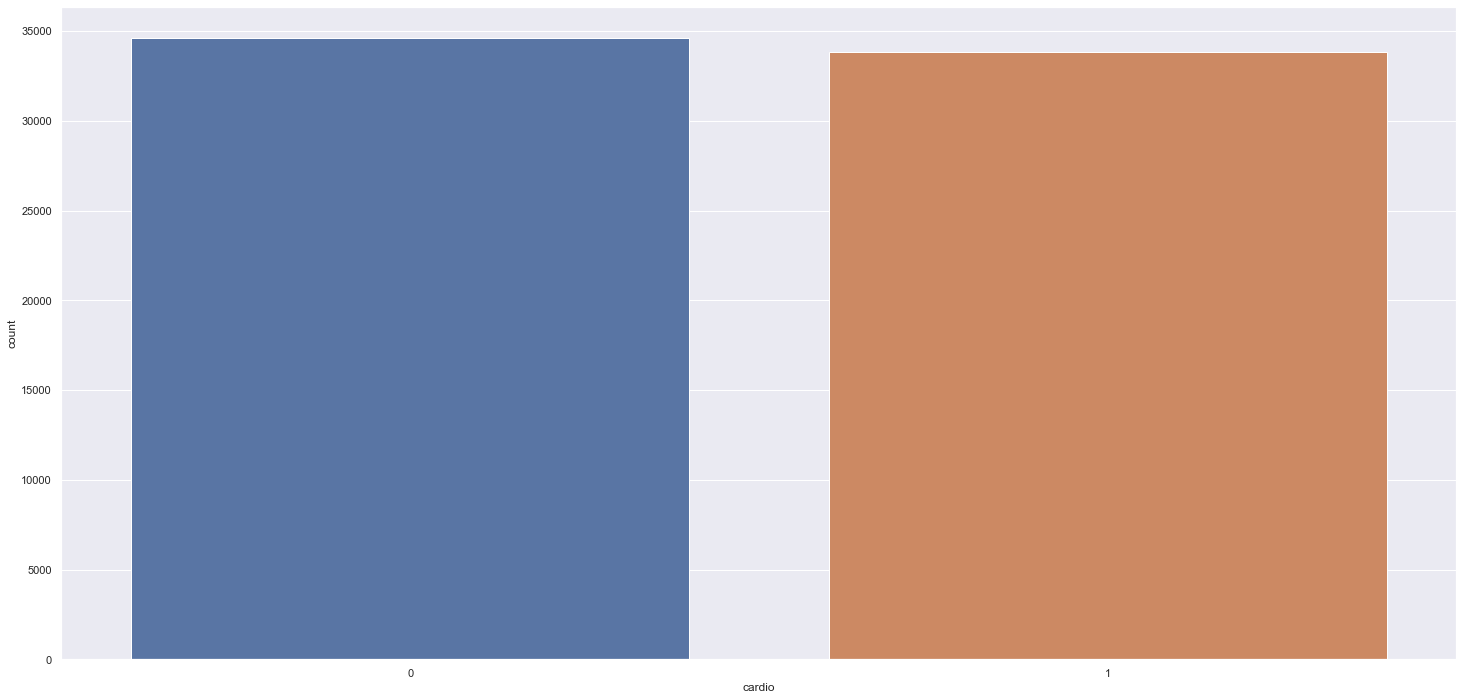

In [34]:
#presence x absence of cardiovascular diseases
sns.countplot(df4['cardio'])

print("Patients distribution:")
print(df4.groupby(['cardio'])['cardio'].count())

### 4.1.2 Numerical Variables

In [35]:
#selecting numerical variables
num_attributes = df4.select_dtypes(exclude = ['object'])

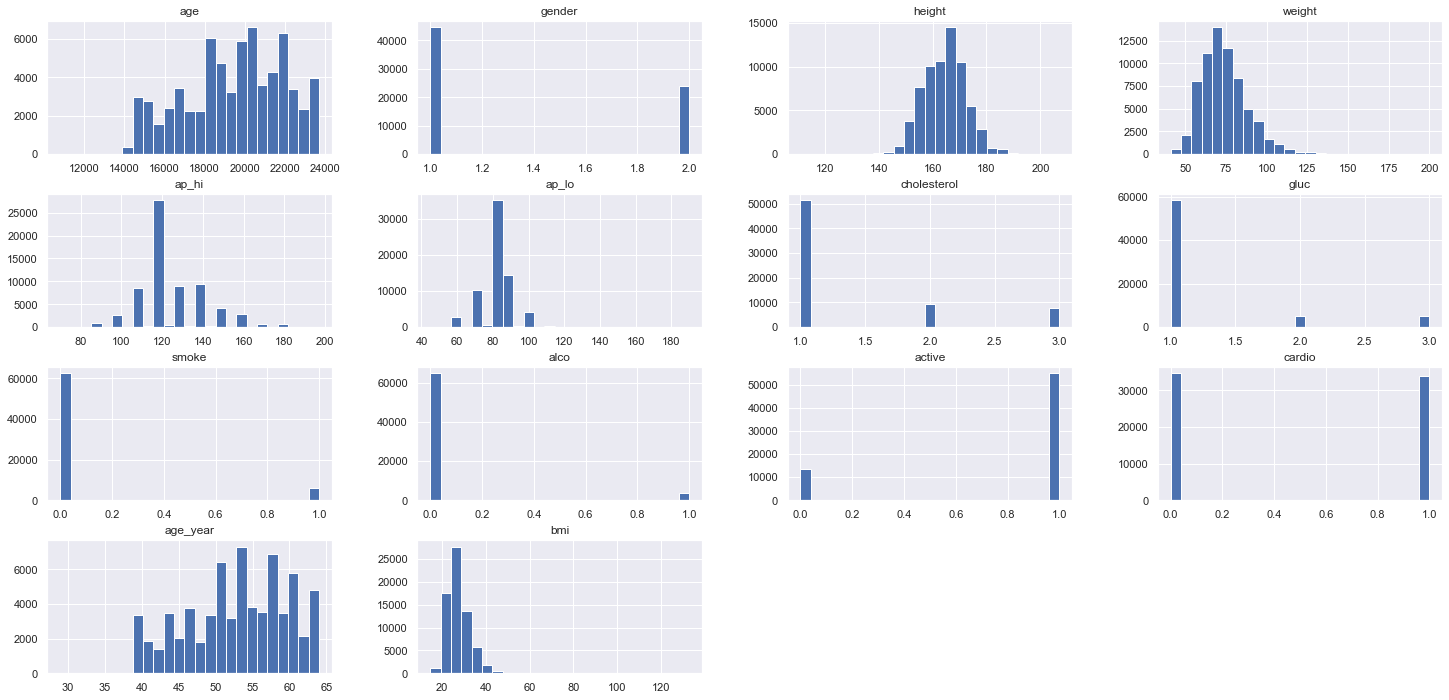

In [36]:
#plotting histogram
num_attributes.hist(bins = 25);

### 4.1.3 Categorical Variable

In [37]:
#selecting "categorical" variables
cat_attributes = df4[['blood_pressure','status_bmi','age_range']]

<AxesSubplot:xlabel='age_range', ylabel='count'>

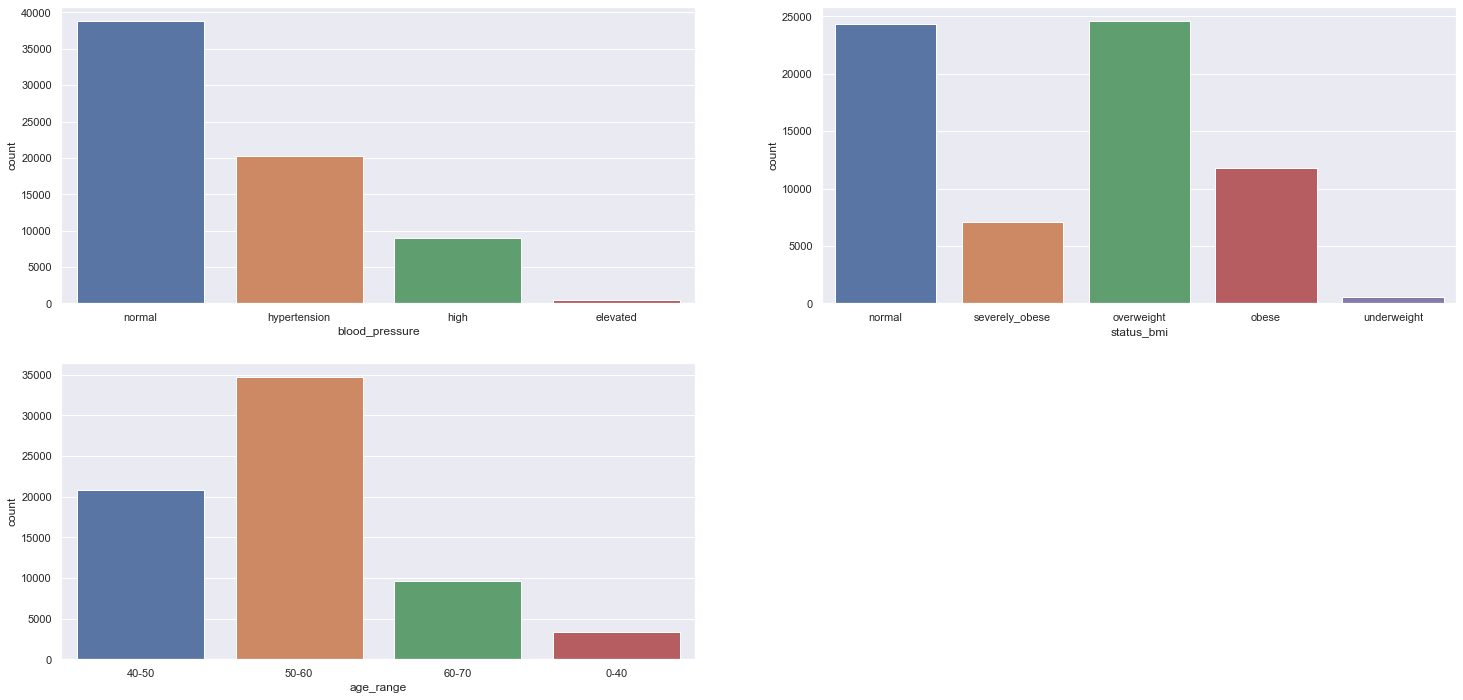

In [38]:
#plotting each variable
plt.subplot(2,2,1)
sns.countplot(cat_attributes['blood_pressure'])

plt.subplot(2,2,2)
sns.countplot(cat_attributes['status_bmi'])

plt.subplot(2,2,3)
sns.countplot(cat_attributes['age_range'])


## 4.2. Bivariate Analysis

### H1. Cardiovascular diseases are more common in older people
**True**- Cardiovascular diseases are more common in older people.

<AxesSubplot:xlabel='age_year', ylabel='cardio'>

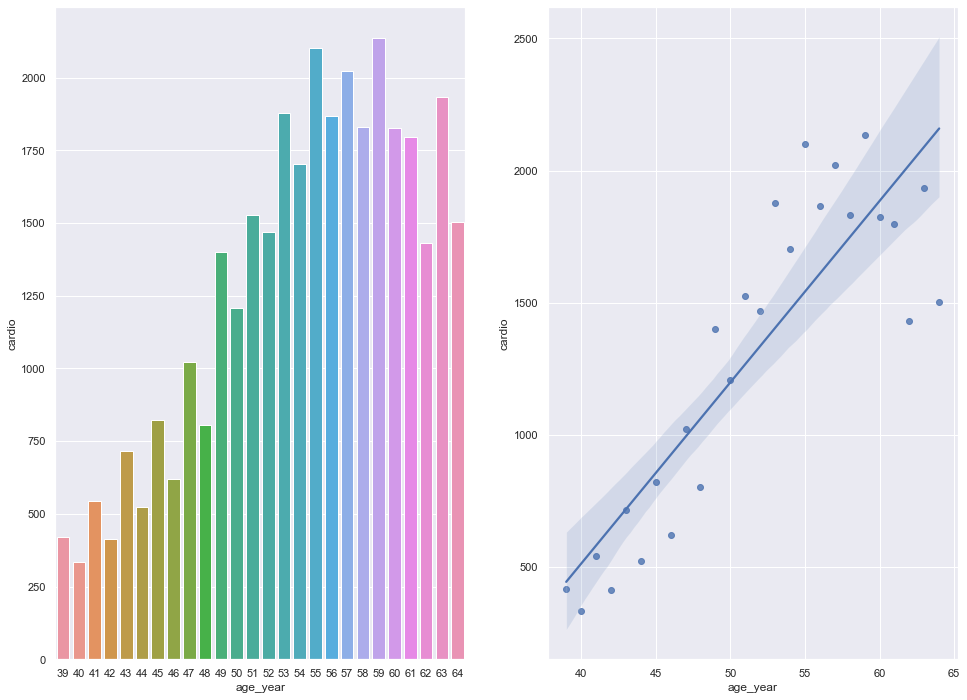

In [39]:
# age x cardio diseases
aux1 = df4[df4['cardio'] == 1]
aux2 = aux1[['age_year','cardio']].groupby(["age_year"]).count().reset_index()

# barplot
plt.subplot(1,3,1)
sns.barplot(x = 'age_year', y = 'cardio', data = aux2)

#regression plot
plt.subplot(1,3,2)
sns.regplot(x = 'age_year', y = 'cardio', data = aux2)

In [40]:
#correlation between variables
df4[['age_year','cardio']].corr(method = 'pearson')

,age_year,cardio
age_year,1.000000,0.239317
cardio,0.239317,1.000000


### H2. Gender does not affect the presence of cardiovascular diseases
There are twice as many cases of cardiovascular diseases in gender 1, but the correlation between gender and cardio diseases is weak.

Text(0.5, 1.0, 'People who have cardiovascular diseases')

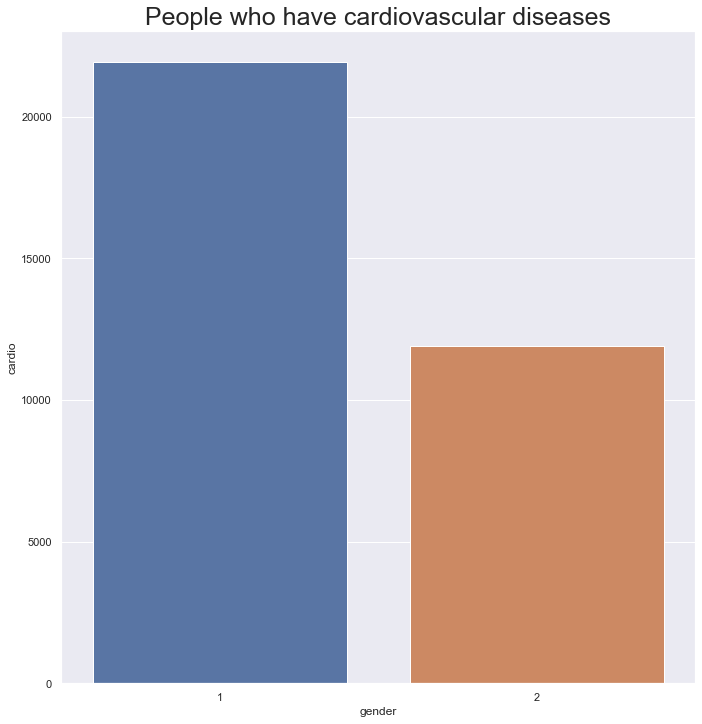

In [41]:
#gender x cardio 
aux1 = df4[df4['cardio'] == 1]
aux2 = aux1[['gender','cardio']].groupby("gender").count().reset_index()

#mean age per gender

#barplot
plt.subplot(1,2,2)
sns.barplot(x = 'gender', y = 'cardio', data = aux2)
plt.title("People who have cardiovascular diseases", fontsize = 25)

In [42]:
#correlation between variables
df4[['gender','cardio']].corr(method = 'pearson')

,gender,cardio
gender,1.000000,0.006668
cardio,0.006668,1.000000


### H3. People with higher diastolic and systolic blood pressure are more likely to have heart diseases
Patients with high blood pressure are more likely to have heart diseases.

Text(0.5, 1.0, 'Cardio = 1')

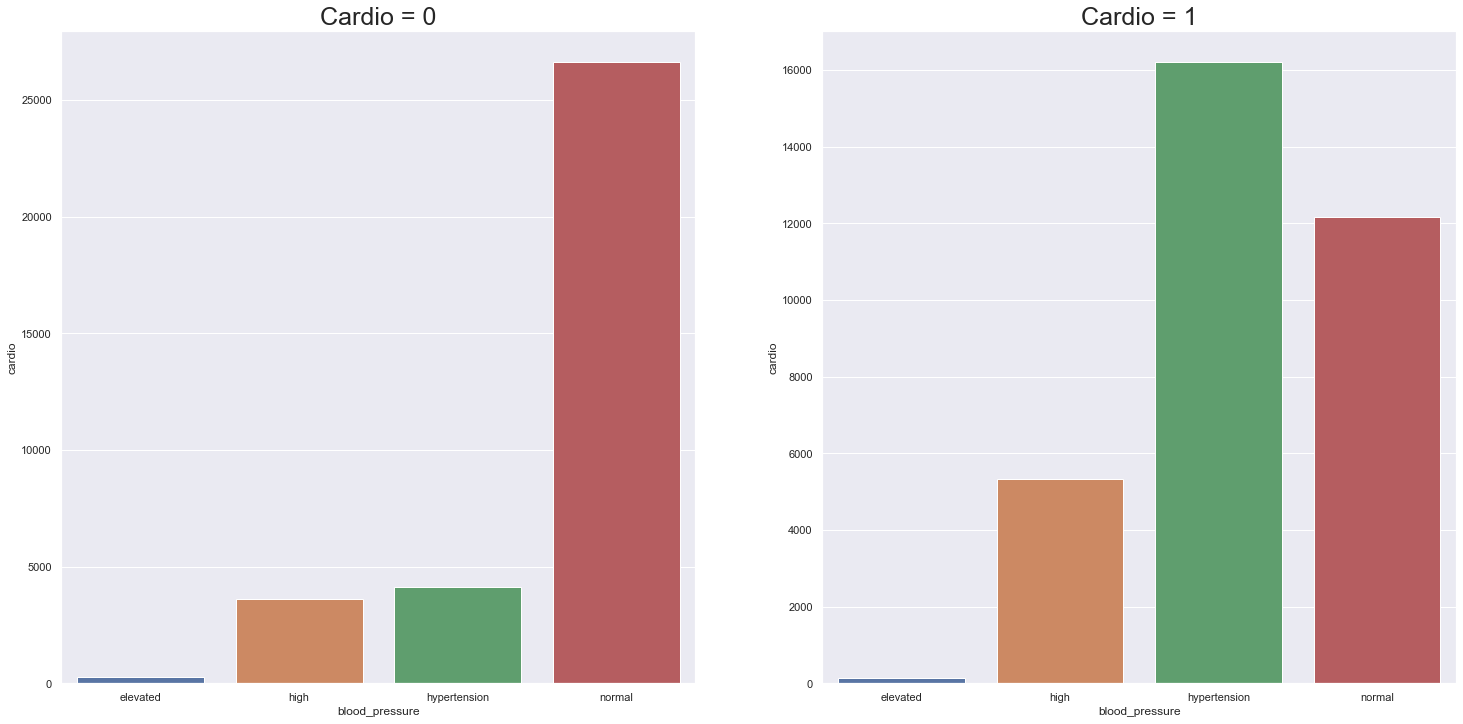

In [43]:
#blood pressure x no cardio diseases
aux1 = df4[df4['cardio'] == 0]
aux2 = aux1[['blood_pressure','cardio']].groupby('blood_pressure').count().reset_index()

plt.subplot(1,2,1)
sns.barplot(x = 'blood_pressure', y = 'cardio', data = aux2)
plt.title("Cardio = 0", fontsize = 25)

#blood pressure x cardio diseases
aux3 = df4[df4['cardio'] == 1]
aux4 = aux3[['blood_pressure','cardio']].groupby('blood_pressure').count().reset_index()

plt.subplot(1,2,2)
sns.barplot(x = 'blood_pressure', y = 'cardio', data = aux4)
plt.title("Cardio = 1", fontsize = 25)


In [44]:
#correlation between variables - systolic pressure
df4[['ap_hi','cardio']].corr(method = 'pearson')

,ap_hi,cardio
ap_hi,1.000000,0.429061
cardio,0.429061,1.000000


In [45]:
#correlation between variables - diastolic pressure
df4[['ap_lo','cardio']].corr(method = 'pearson')

,ap_lo,cardio
ap_lo,1.000000,0.336045
cardio,0.336045,1.000000


### H4. There are more cases of cardiovascular diseases among people who smoke
**False**- Smoking does not seem to be related to cardiovascular diseases.

In [46]:
aux4

,blood_pressure,cardio
0,elevated,148
1,high,5328
2,hypertension,16210
3,normal,12167


Text(0.5, 1.0, 'Cardio = 1')

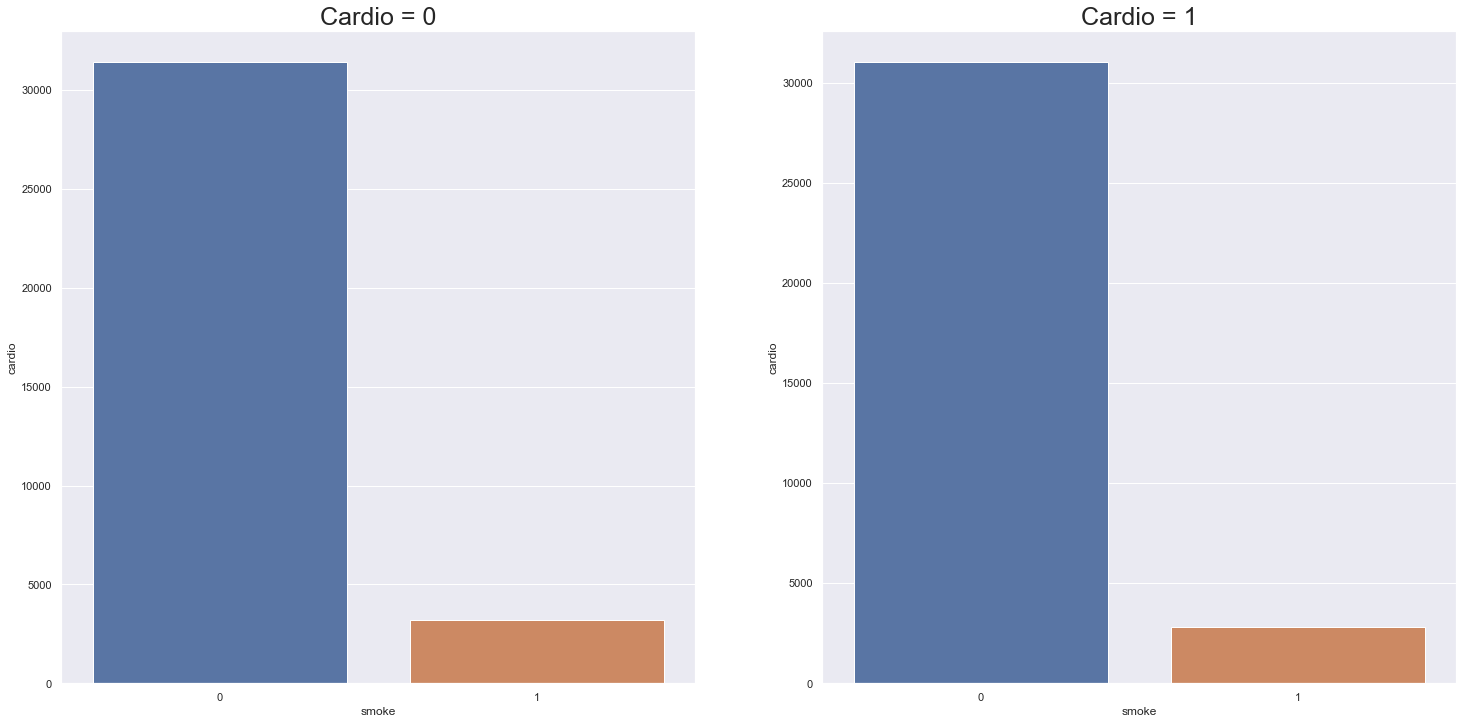

In [47]:
#people who dont smoke
aux1 = df4[df4['cardio'] == 0]
aux2 = aux1[['smoke','cardio']].groupby("smoke").count().reset_index()

#plot
plt.subplot(1,2,1)
sns.barplot(x = 'smoke', y = 'cardio', data = aux2)
plt.title("Cardio = 0", fontsize = 25)

#people who smoke
aux3 = df4[df4['cardio'] == 1]
aux4 = aux3[['smoke','cardio']].groupby("smoke").count().reset_index()

#plot
plt.subplot(1,2,2)
sns.barplot(x = 'smoke', y = 'cardio', data = aux4)
plt.title("Cardio = 1", fontsize = 25)

In [48]:
#correlation between variables
df4[['smoke','cardio']].corr(method = 'pearson')

,smoke,cardio
smoke,1.00000,-0.01678
cardio,-0.01678,1.00000


### H5. There are more cases of cardiovascular diseases among people who drink alcohol
**False** - Drinking does not seem to be related to cardiovascular diseases.

Text(0.5, 1.0, 'Cardio = 1')

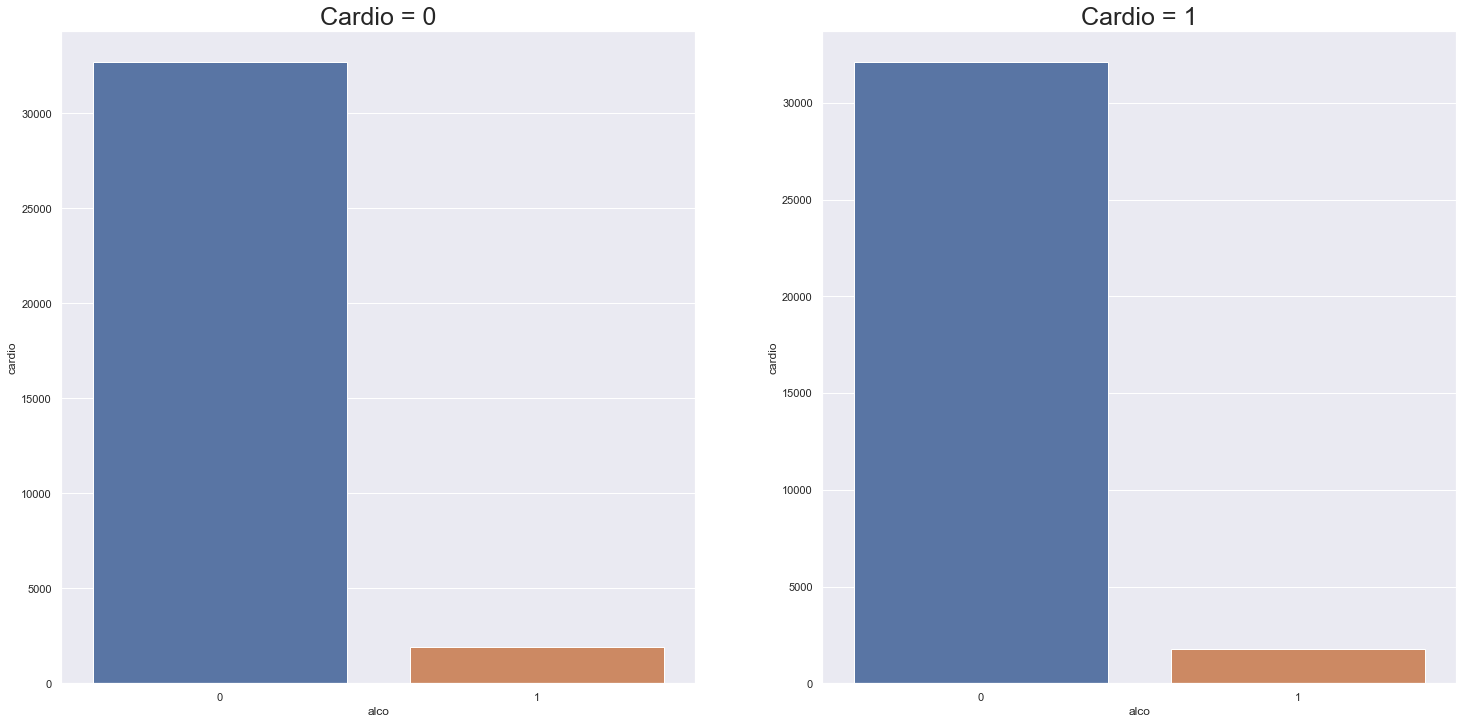

In [49]:
#people who dont drink regularly
aux1 = df4[df4['cardio'] == 0]
aux2 = aux1[['alco','cardio']].groupby("alco").count().reset_index()

#plot
plt.subplot(1,2,1)
sns.barplot(x = 'alco', y = 'cardio', data = aux2)
plt.title("Cardio = 0", fontsize = 25)

#people who drink regularly
aux3 = df4[df4['cardio'] == 1]
aux4 = aux3[['alco','cardio']].groupby("alco").count().reset_index()

#plot
plt.subplot(1,2,2)
sns.barplot(x = 'alco', y = 'cardio', data = aux4)
plt.title("Cardio = 1", fontsize = 25)

In [50]:
#correlation between variables
df4[['alco','cardio']].corr(method = 'pearson')

,alco,cardio
alco,1.000000,-0.008485
cardio,-0.008485,1.000000


### H6. Obese and overweight persons are more likely to have cardiovascular diseases
Overweight people have a higher risk of having cardiovascular diseases - the relationship between weight and cardiovascular diseases is positive.

Text(0.5, 1.0, 'Cardio = 1')

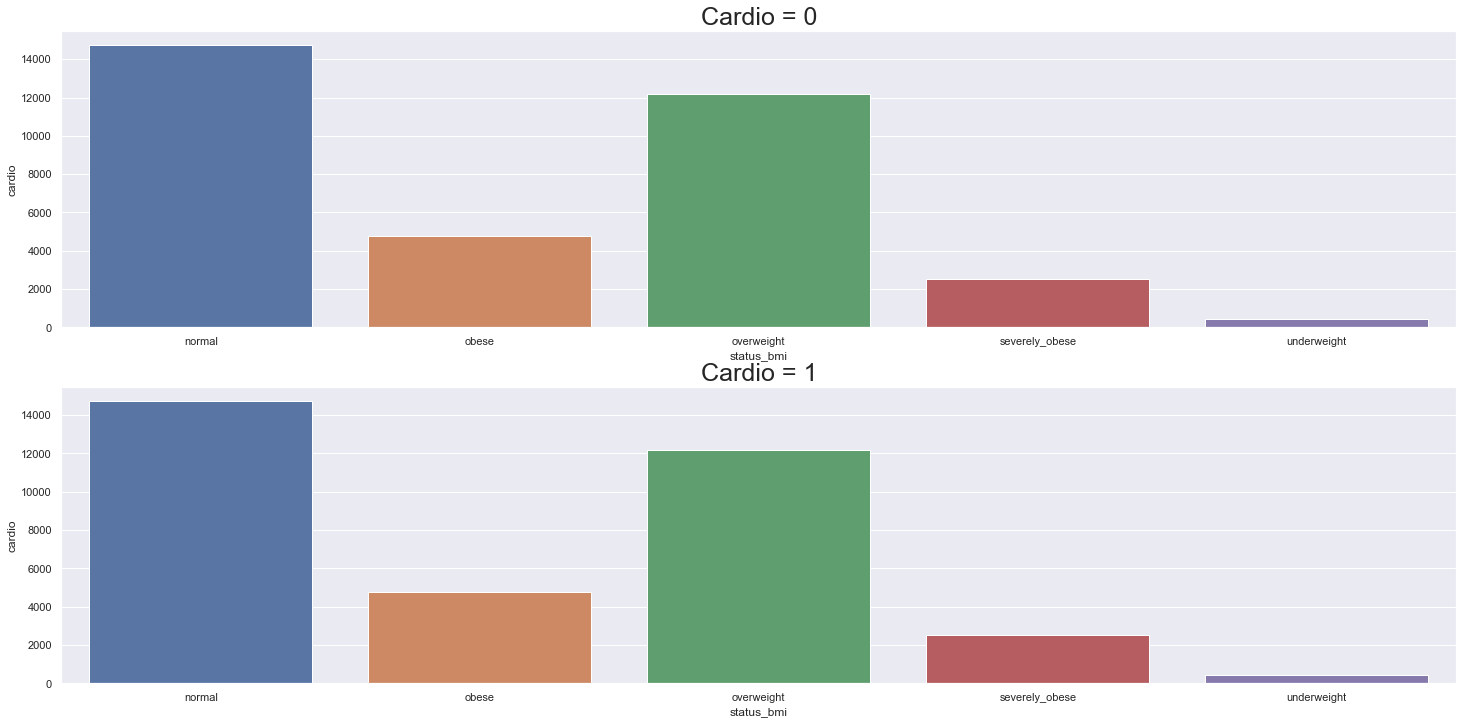

In [51]:
#people 
aux1 = df4[df4['cardio'] == 0]
aux2 = aux1[['status_bmi','cardio']].groupby("status_bmi").count().reset_index()

#plot1 - BMI X CARDIO (BARPLOT)
plt.subplot(2,1,1)
sns.barplot(x = 'status_bmi', y = 'cardio', data = aux2)
plt.title("Cardio = 0",fontsize = 25)

#
aux3 = df4[df4['cardio'] == 1]
aux4 = aux3[['status_bmi','cardio']].groupby("status_bmi").count().reset_index()

#plot1 - BMI X CARDIO (BARPLOT)
plt.subplot(2,1,2)
sns.barplot(x = 'status_bmi', y = 'cardio', data = aux2)
plt.title("Cardio = 1",fontsize = 25)


(0.0, 60.0)

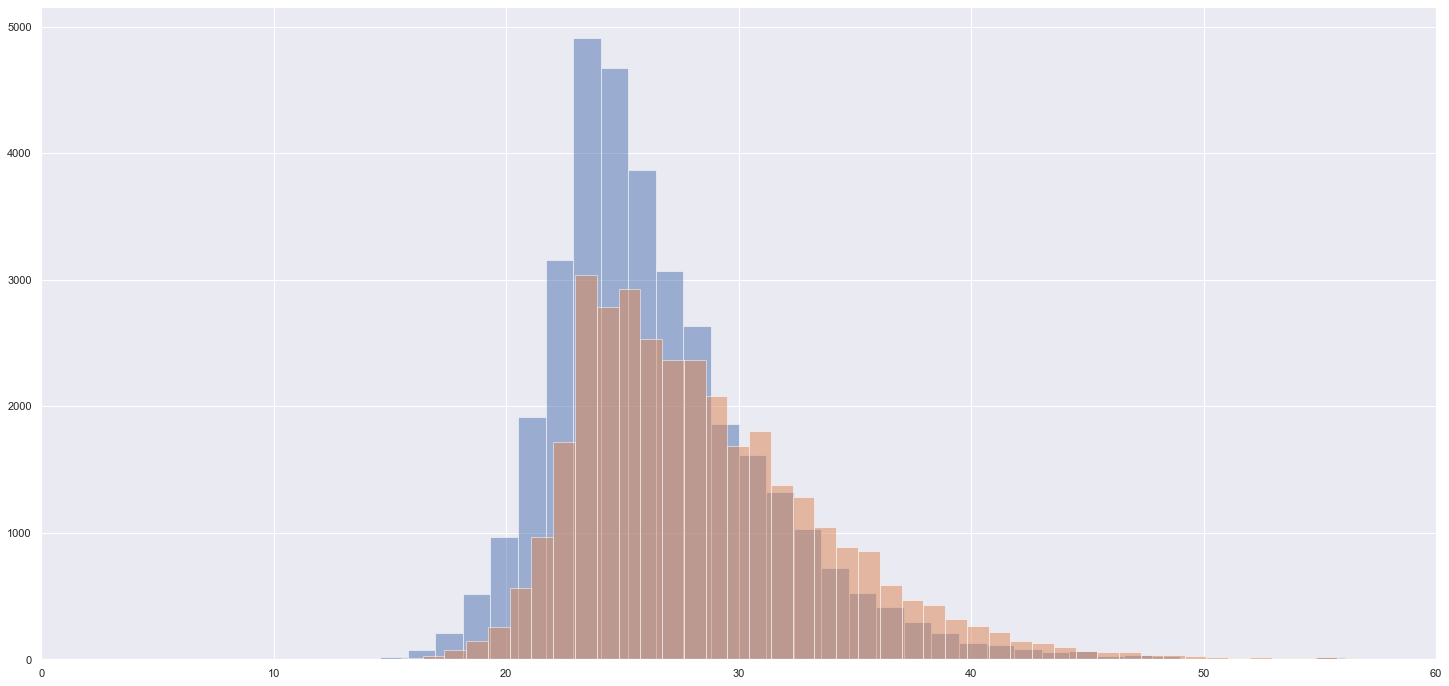

In [52]:
#plot bmi distribution for cardio=0 and cardio=1
plt.hist(aux1["bmi"], bins=100, alpha=0.5)
plt.hist(aux3["bmi"], bins=100, alpha=0.5)
plt.xlim(0, 60)

In [53]:
#correlation between variables
df4[['bmi','cardio']].corr(method = 'pearson')

,bmi,cardio
bmi,1.000000,0.187807
cardio,0.187807,1.000000


### H7. There are fewer cases of cardiovascular diseases in people who exercise regularly
There are more cases of cardiovascular diseases in people who don't practice physical activity, but the correlation is weak.

<AxesSubplot:xlabel='active', ylabel='count'>

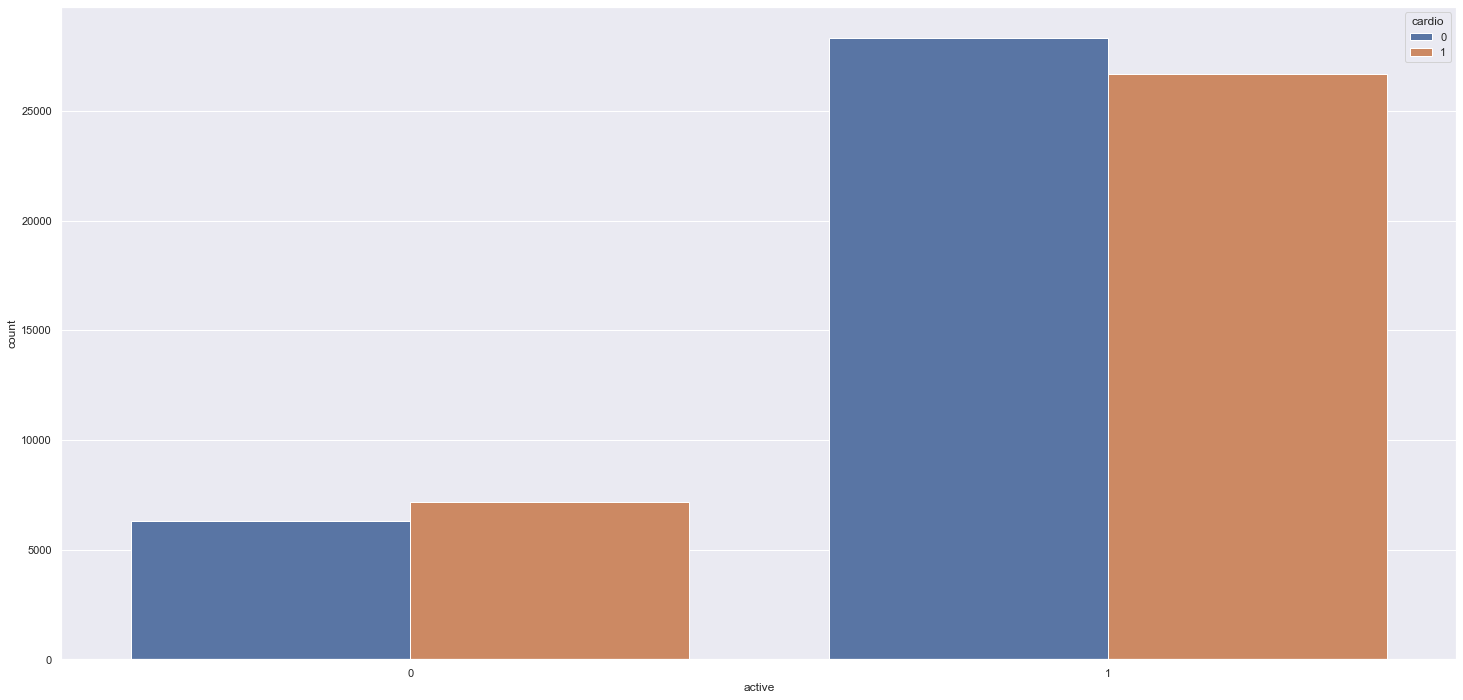

In [54]:
#plot exercise x cardio diseases
sns.countplot(x = 'active', hue = 'cardio', data = df4)

In [55]:
#correlation between variables
df4[['active','cardio']].corr(method = 'pearson')

,active,cardio
active,1.000000,-0.037311
cardio,-0.037311,1.000000


### H8. People with high glucose rates are more likely to have heart diseases
There are more cases of cardiovascular diseases in people who have a high glucose rate, but the correlation is week.

<AxesSubplot:xlabel='gluc', ylabel='count'>

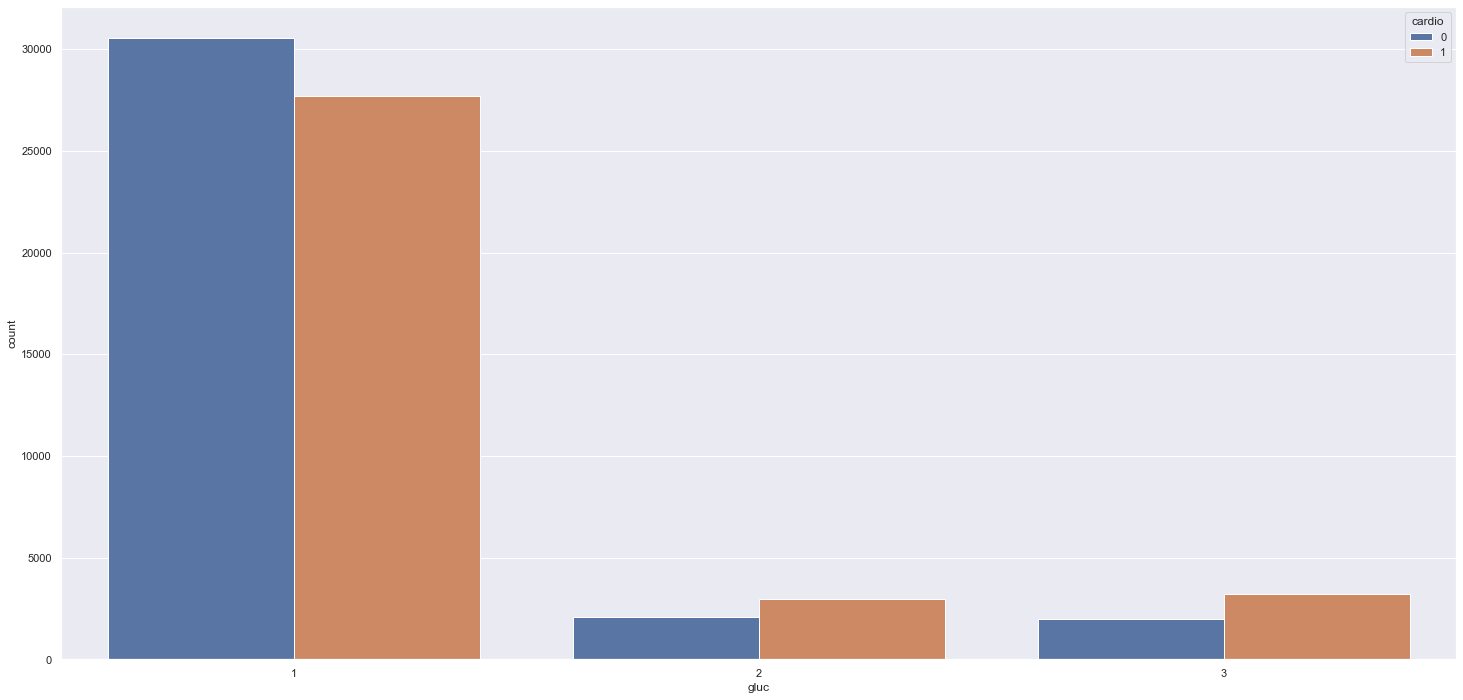

In [56]:
#plot glucose levels x cardio diseases
sns.countplot(x = 'gluc', hue = 'cardio', data = df4)

In [57]:
#correlation between variables
df4[['gluc','cardio']].corr(method = 'pearson')

,gluc,cardio
gluc,1.000000,0.089455
cardio,0.089455,1.000000


### H9. There are more cases of cardiovascular diseases among people with high cholesterol levels
**True** - There are more cases of cardiovascular diseases in people who have high cholesterol levels

<AxesSubplot:xlabel='cholesterol', ylabel='count'>

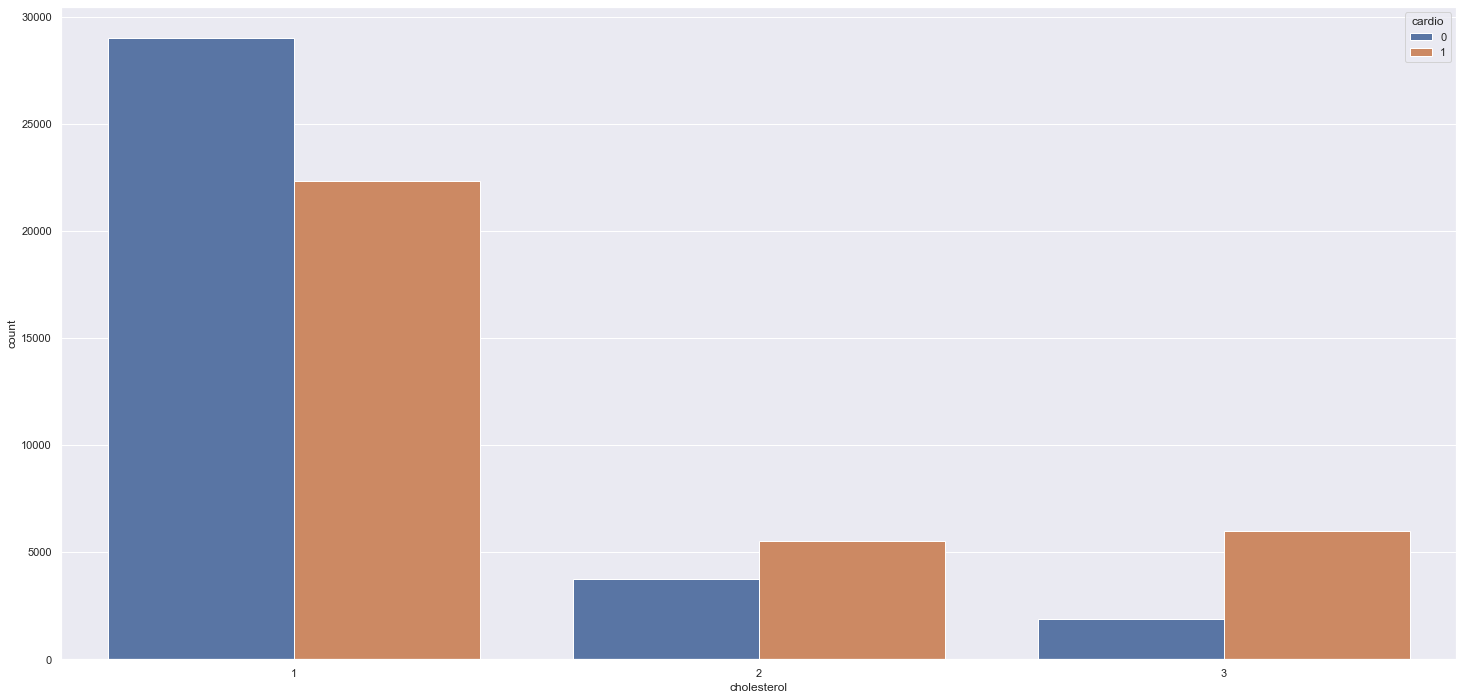

In [58]:
#plot cholesterol levels x cardio diseases
sns.countplot(x = 'cholesterol', hue = 'cardio', data = df4)

In [59]:
#correlation between variables
df4[['cholesterol','cardio']].corr(method = 'pearson')

,cholesterol,cardio
cholesterol,1.000000,0.221277
cardio,0.221277,1.000000


### H10. Height does not affect the presence of cardiovascular diseases
**True** - Height does not affect the presence of cardiovascular diseases.

<AxesSubplot:xlabel='height', ylabel='count'>

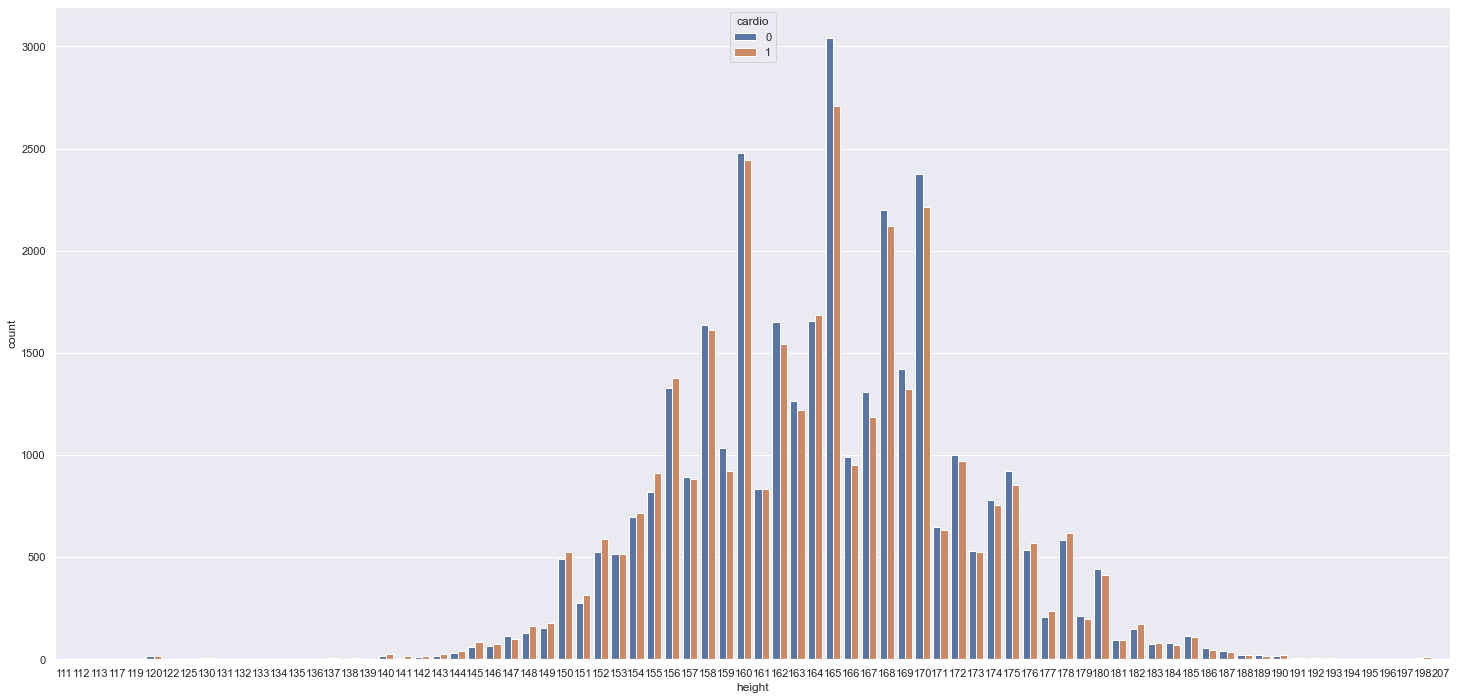

In [60]:
#plot height x cardio diseases
sns.countplot(x = 'height', hue = 'cardio', data = df4)

In [61]:
#correlation between variables
df4[['height','cardio']].corr(method = 'pearson')

,height,cardio
height,1.000000,-0.013143
cardio,-0.013143,1.000000


### 4.2.2 Summary of Hypotheses

## 4.3. Multivariate Analysis

<AxesSubplot:>

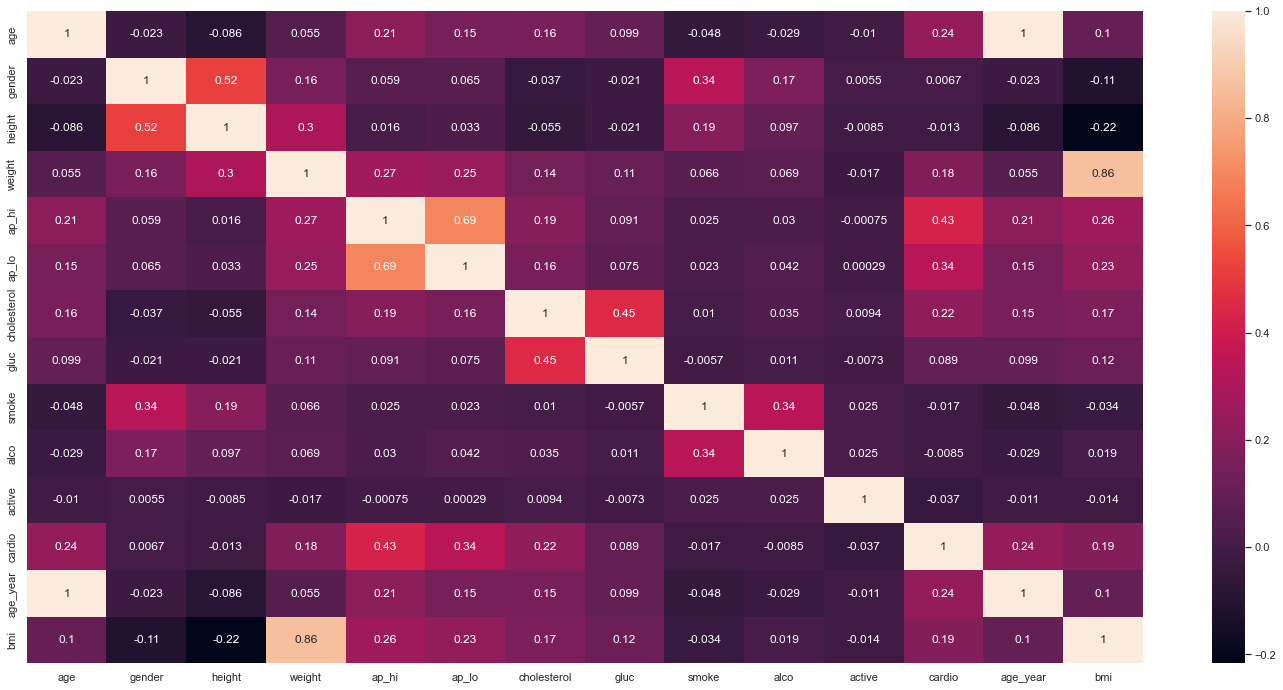

In [62]:
#numerical variables
aux1 = df4.select_dtypes(exclude = ['object'])

# correlation plot with all variables
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

# 5.0. DATA PREPARATION

In [63]:
df5 = df4.copy()
df5.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year,blood_pressure,bmi,status_bmi,age_range
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,normal,21.97,normal,40-50
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,hypertension,34.93,severely_obese,50-60
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,high,23.51,normal,50-60
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,hypertension,28.71,overweight,40-50
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,normal,23.01,normal,40-50


## 5.1 Variables exploration

<AxesSubplot:xlabel='bmi', ylabel='Density'>

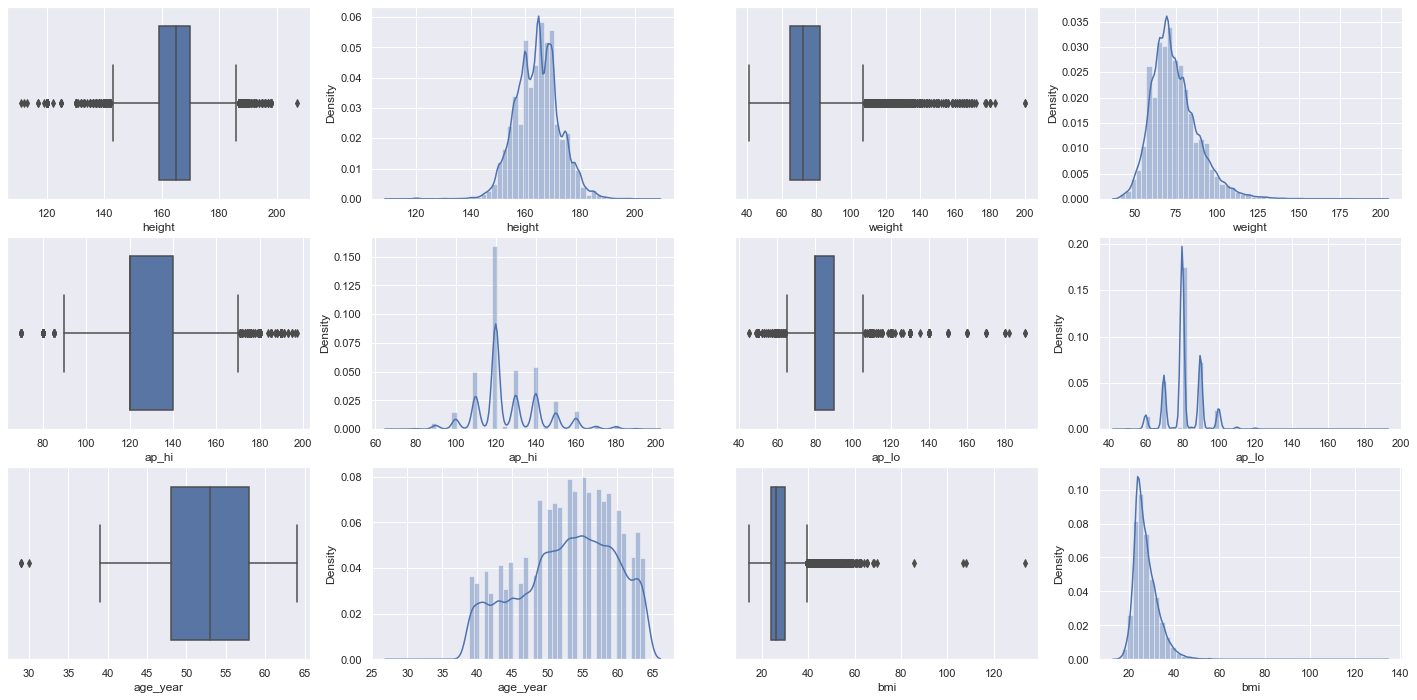

In [64]:
#ploting histogram and boxplot for each variable

#height
plt.subplot(3,4,1)
sns.boxplot(df5['height'])

plt.subplot(3,4,2)
sns.distplot(df5['height'])

#weight
plt.subplot(3,4,3)
sns.boxplot(df5['weight'])

plt.subplot(3,4,4)
sns.distplot(df5['weight'])

#ap_hi
plt.subplot(3,4,5)
sns.boxplot(df5['ap_hi'])

plt.subplot(3,4,6)
sns.distplot(df5['ap_hi'])

#ap_lo
plt.subplot(3,4,7)
sns.boxplot(df5['ap_lo'])

plt.subplot(3,4,8)
sns.distplot(df5['ap_lo'])

#age_year
plt.subplot(3,4,9)
sns.boxplot(df5['age_year'])

plt.subplot(3,4,10)
sns.distplot(df5['age_year'])

#bmi
plt.subplot(3,4,11)
sns.boxplot(df5['bmi'])

plt.subplot(3,4,12)
sns.distplot(df5['bmi'])

## 5.2. Rescaling

- RobustScaler - Variables with too many outliers
    - ap_lo
    - ap_hi
    - weight
    - bmi 

- MinMaxScaler - Variables with few or no outliers 
    - age_year
    - height

In [65]:
#defining rescaling functions
rs = RobustScaler()
mms = MinMaxScaler()

#ap_lo - RobustScaler
df5['ap_lo'] = rs.fit_transform(df5[['ap_lo']].values)

#ap_hi - RobustScaler
df5['ap_hi'] = rs.fit_transform(df5[['ap_hi']].values)

#weight - RobustScaler
df5['weight'] = rs.fit_transform(df5[['weight']].values)

#bmi - RobustScaler
df5['bmi'] = rs.fit_transform(df5[['bmi']].values)

#age_year - MinMaxScaler
df5['age_year'] = mms.fit_transform(df5[['age_year']].values)

#height - MinMaxScaler 
df5['height'] = mms.fit_transform(df5[['height']].values)

## 5.3. Transformation

In [66]:
#blood_pressure - OrdinalEncoding
dict_blood = {'normal':1, 'elevated':2,'high':3, 'hypertension':4}
df5['blood_pressure'] = df5['blood_pressure'].map(dict_blood)

#status_bmi - OrdinalEncoding
dict_bmi = {'underweight':1,'normal':2,'overweight':3,'obese':4,'severely_obese':5}
df5['status_bmi'] = df5['status_bmi'].map(dict_bmi)

#age_range - OrdinalEncoding
dict_age_range = {"0-40":0,"40-50":1,"50-60":2,"60-70":3, ">65":4}
df5['age_range'] = df5['age_range'].map(dict_age_range)
                                

# 6.0. FEATURE SELECTION

In [67]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [68]:
#define response and explanatory variables
X = df6.drop(['cardio'], axis = 1)
y = df6['cardio']

#split data into training and test dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)

## 6.2. Boruta as Feature Selector

In [69]:
#define model
xgb_model = xgb.XGBClassifier(n_jobs=-1)
extra_model = ExtraTreesClassifier(n_jobs=-1)
rf_model = RandomForestClassifier(n_jobs = -1)

#split data 
X_train_nn = X_train.values
y_train_nn = y_train.values.ravel()

#define boruta
boruta = BorutaPy(extra_model, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_nn, y_train_nn)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	10


In [70]:
#best features from boruta
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['age', 'weight', 'ap_hi', 'age_year', 'blood_pressure', 'bmi']

Selected fetures:

- weight
- ap_hi 
- age
- blood_pressure
- bmi



## 6.3. Manual Feature Selection

<AxesSubplot:>

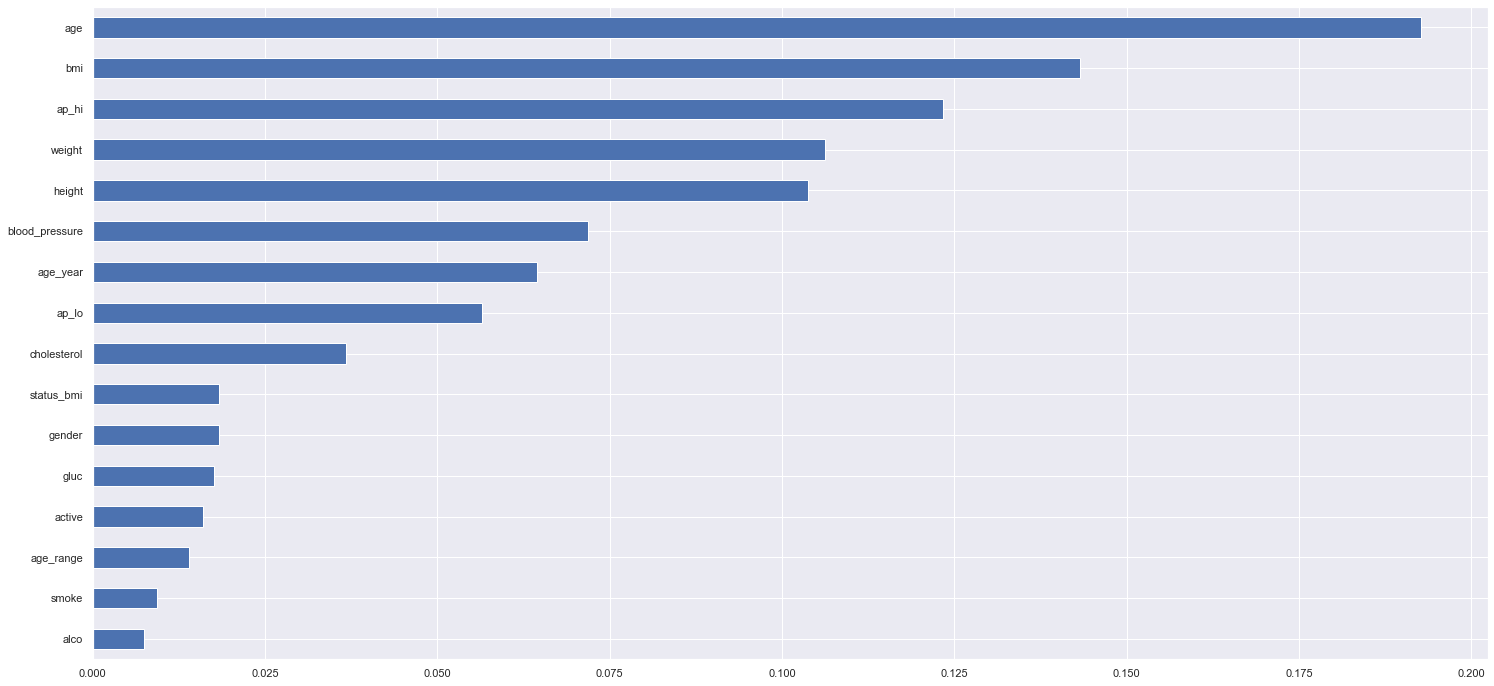

In [71]:
#ploting features importance 
rf_model.fit(X_train, y_train)

feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')

## 6.4. Final selection

In [72]:
#final feature selection
cols_selected_boruta_full = ['weight','ap_hi','ap_lo','age_year','age','blood_pressure','bmi','cholesterol']

In [73]:
#creating a dataframe with selected columns
X_train_boruta = X_train[cols_selected_boruta_full].copy()
X_test_boruta = X_test[cols_selected_boruta_full].copy()

# 7.0. MACHINE LEARNING MODELLING

- K-Nearest Neighbors
- Random Forest Classifier
- XGBoost Classifier
- LGBM Classifier

In [74]:
#copying data
X_train = X_train_boruta.copy()
X_test = X_test_boruta.copy()

## 7.1. K-Nearest Neighbors

In [147]:
#model definition
knn = KNeighborsClassifier(n_neighbors = 5)

#fit model
knn.fit(X_train,y_train)

#predict model
yhat_knn = knn.predict(X_test)

# AUC-ROC curve
knn_cv = cross_val_predict(knn, X_train, y_train, cv=5)
knn_roc = roc_auc_score(y_train, knn_cv)

#performance
result_knn = pd.DataFrame(["KNearestNeighbors",accuracy_score(y_test,yhat_knn),cohen_kappa_score(y_test,yhat_knn),
                          recall_score(y_test,yhat_knn), f1_score(y_test,yhat_knn),knn_roc,
                          precision_score(y_test,yhat_knn)]).T
result_knn.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","roc_auc_score","Precision_score"]
print(result_knn)

#classification_report
print(classification_report(y_test, yhat_knn))

#confusion_matrix
print("Confusion Matrix:")
print(mt.confusion_matrix(y_test,yhat_knn))

               Model  Accuracy Kappa Score    Recall  F1-Score roc_auc_score  \
0  KNearestNeighbors  0.674577    0.348751  0.648014  0.663241      0.667849   

  Precision_score  
0        0.679201  
              precision    recall  f1-score   support

           0       0.67      0.70      0.69      6923
           1       0.68      0.65      0.66      6773

    accuracy                           0.67     13696
   macro avg       0.67      0.67      0.67     13696
weighted avg       0.67      0.67      0.67     13696

Confusion Matrix:
[[4850 2073]
 [2384 4389]]


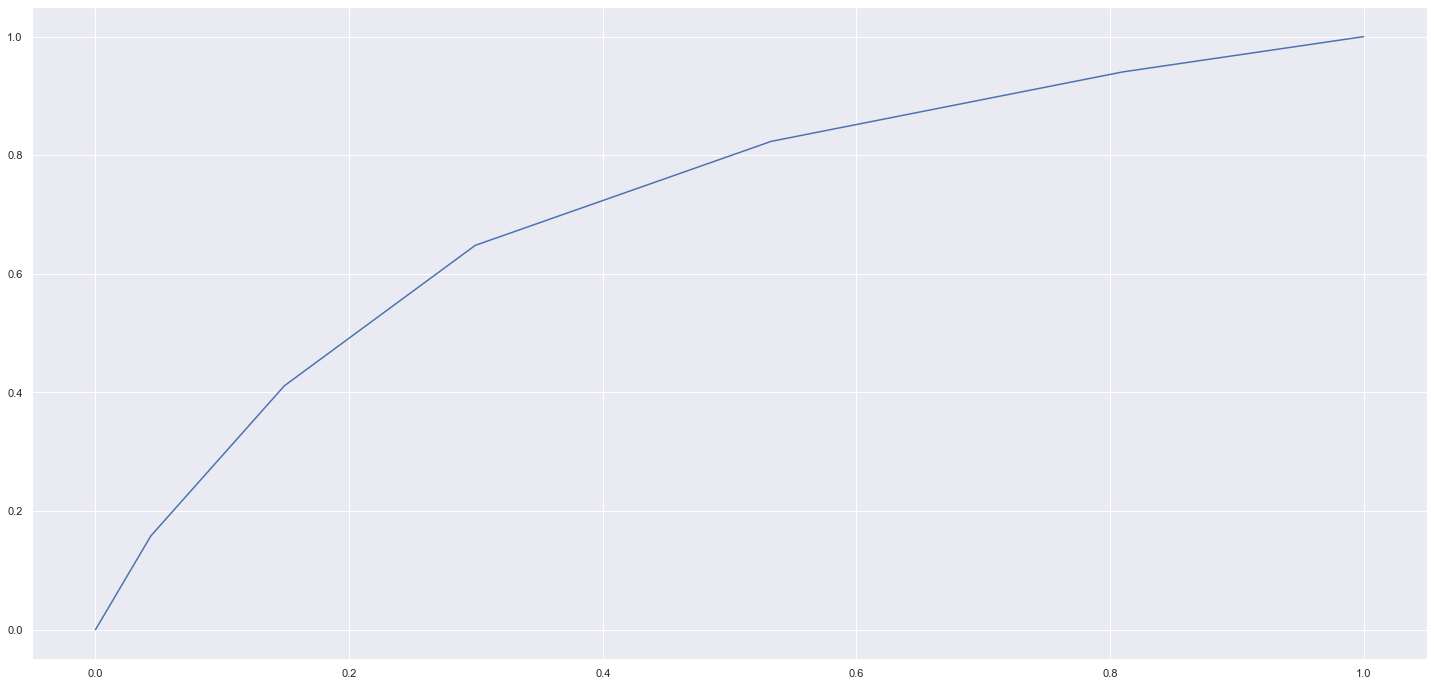

In [136]:
#AUC-ROC curve
probs = knn.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = mt.roc_curve(y_test, preds)
plt.plot(fpr, tpr, 'b', label = 'AUC-ROC curve')

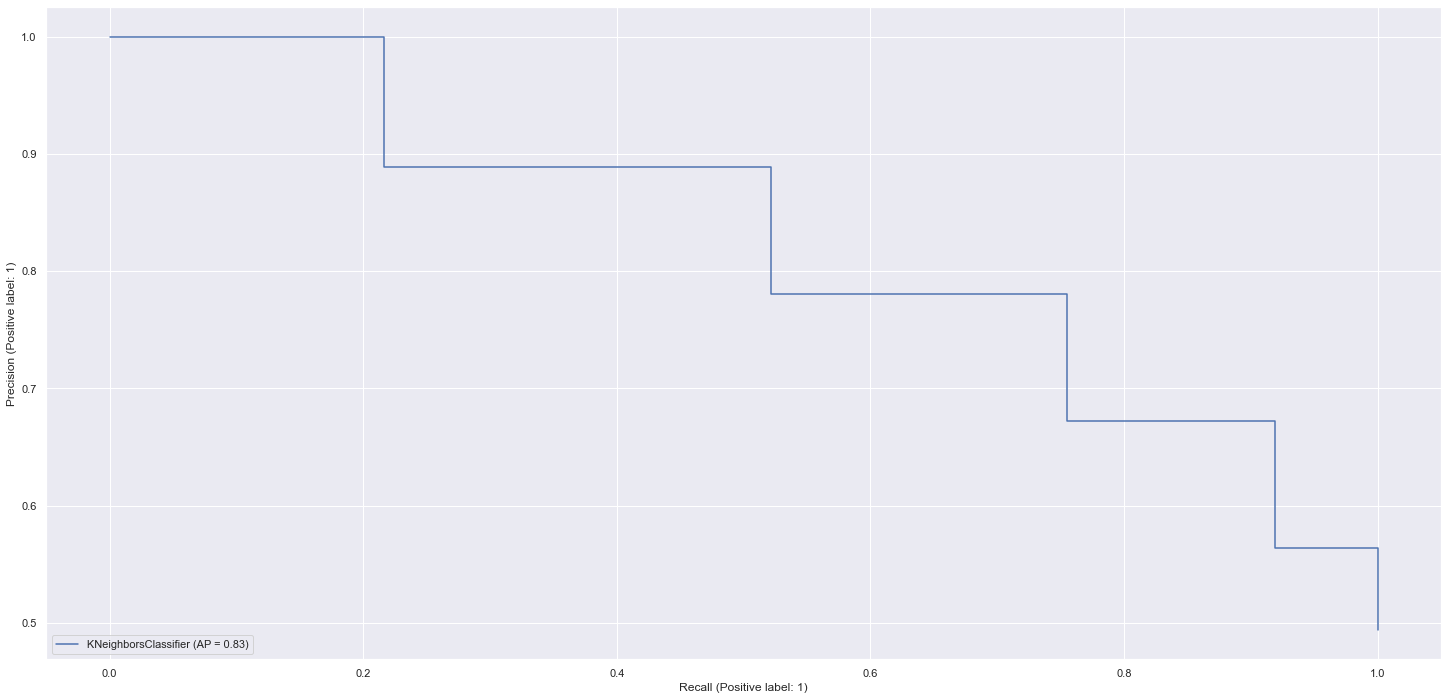

In [135]:
#precision_recall_curve
plot_precision_recall_curve(knn, X_train, y_train)

### 7.1.1. KNN - Cross-Validation

In [143]:
#cross validation scores
knn_cv = cross_val_score(knn,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(knn_cv),4),np.round(np.std(knn_cv),4)))

Average: 0.6689 +/- Std 0.0048


## 7.2. Random Forest Classifier

In [151]:
#define model
rf = RandomForestClassifier(n_jobs = -1)

#training model
rf.fit(X_train, y_train)

#predict model
yhat_rf = rf.predict(X_test)

# AUC-ROC
rf_cv = cross_val_predict(rf, X_train, y_train, cv=5)
rf_roc = roc_auc_score(y_train, rf_cv)

#performance
result_rf = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf),cohen_kappa_score(y_test,yhat_rf),
                          recall_score(y_test,yhat_rf), f1_score(y_test,yhat_rf),rf_roc,
                           precision_score(y_test,yhat_rf)]).T
result_rf.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","roc_auc_score","Precision_score"]
print(result_rf)

#classification_report
print(classification_report(y_test, yhat_rf))

#confusion_matrix
print("Confusion matrix:")
print(mt.confusion_matrix(y_test,yhat_rf))

                      Model Accuracy Kappa Score    Recall  F1-Score  \
0  Random Forest Classifier  0.70663    0.412984  0.687288  0.698529   

  roc_auc_score Precision_score  
0      0.703409        0.710145  
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      6923
           1       0.71      0.69      0.70      6773

    accuracy                           0.71     13696
   macro avg       0.71      0.71      0.71     13696
weighted avg       0.71      0.71      0.71     13696

Confusion matrix:
[[5023 1900]
 [2118 4655]]


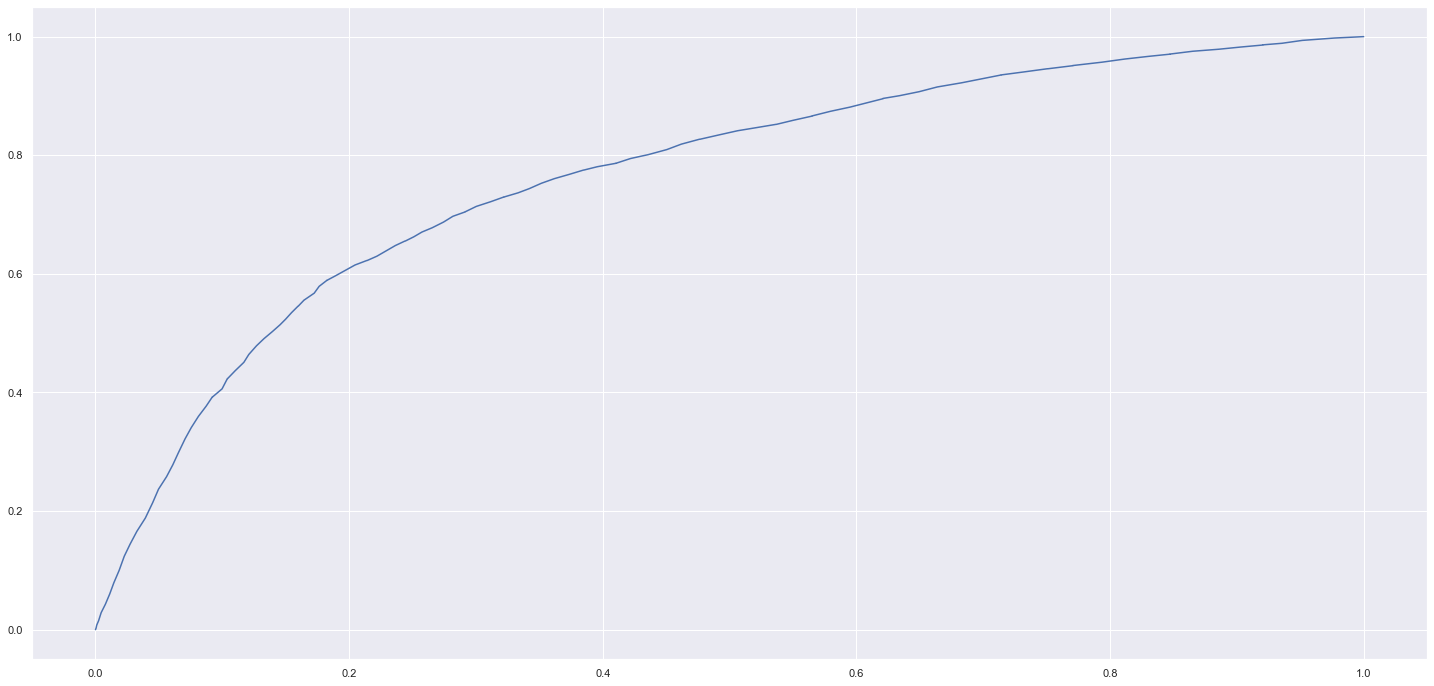

In [152]:
#AUC-ROC curve
probs = rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = mt.roc_curve(y_test, preds)
plt.plot(fpr, tpr, 'b', label = 'AUC-ROC curve')

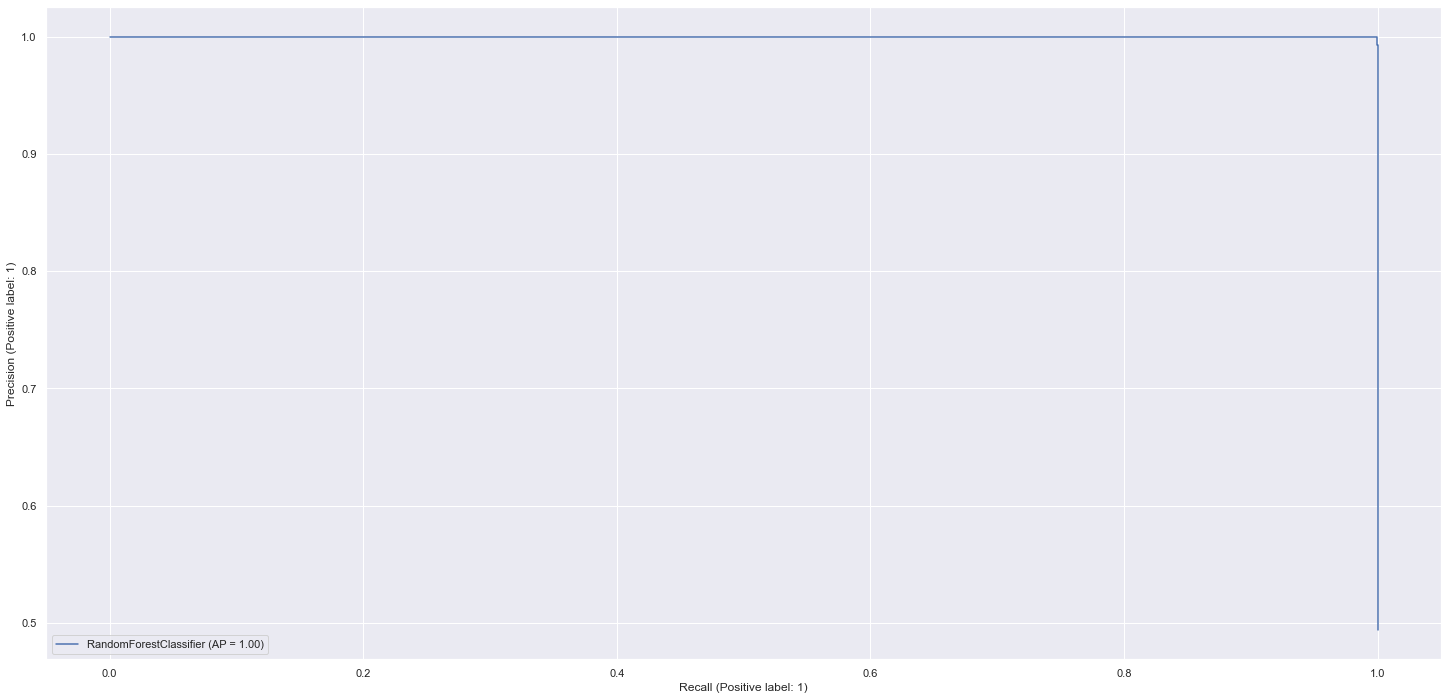

In [154]:
#precision_recall_curve
plot_precision_recall_curve(rf, X_train, y_train)

### 7.2.1. RandomForestClassifier - Cross-Validation - Real Performance

In [155]:
#cross validation scores
rf_cv = cross_val_score(rf,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(rf_cv),4),np.round(np.std(rf_cv),4)))

Average: 0.7032 +/- Std 0.0043


## 7.3. XGBoost Classifier

In [157]:
#model definition
xgb_model = xgb.XGBClassifier(n_jobs = -1)

#fit model
xgb_model.fit(X_train,y_train)

#prediction
yhat_xgb = xgb_model.predict(X_test)

# AUC-ROC curve
xgb_cv = cross_val_predict(xgb_model, X_train, y_train, cv=5)
xgb_roc = roc_auc_score(y_train, xgb_cv)


#performance
result_xgb = pd.DataFrame(["XGBoost Classifier",accuracy_score(y_test,yhat_xgb),cohen_kappa_score(y_test,yhat_xgb),
                          recall_score(y_test,yhat_xgb), f1_score(y_test,yhat_xgb),xgb_roc,
                          precision_score(y_test,yhat_xgb)]).T
result_xgb.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","roc_auc_score","Precision_score"]
print(result_xgb)

#classification_report
print(classification_report(y_test, yhat_xgb))

#confusion_matrix
print("Confusion matrix:")
print(mt.confusion_matrix(y_test,yhat_xgb))

                Model  Accuracy Kappa Score    Recall  F1-Score roc_auc_score  \
0  XGBoost Classifier  0.723423    0.446239  0.675329  0.707174      0.728262   

  Precision_score  
0        0.742171  
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6923
           1       0.74      0.68      0.71      6773

    accuracy                           0.72     13696
   macro avg       0.73      0.72      0.72     13696
weighted avg       0.72      0.72      0.72     13696

Confusion matrix:
[[5334 1589]
 [2199 4574]]


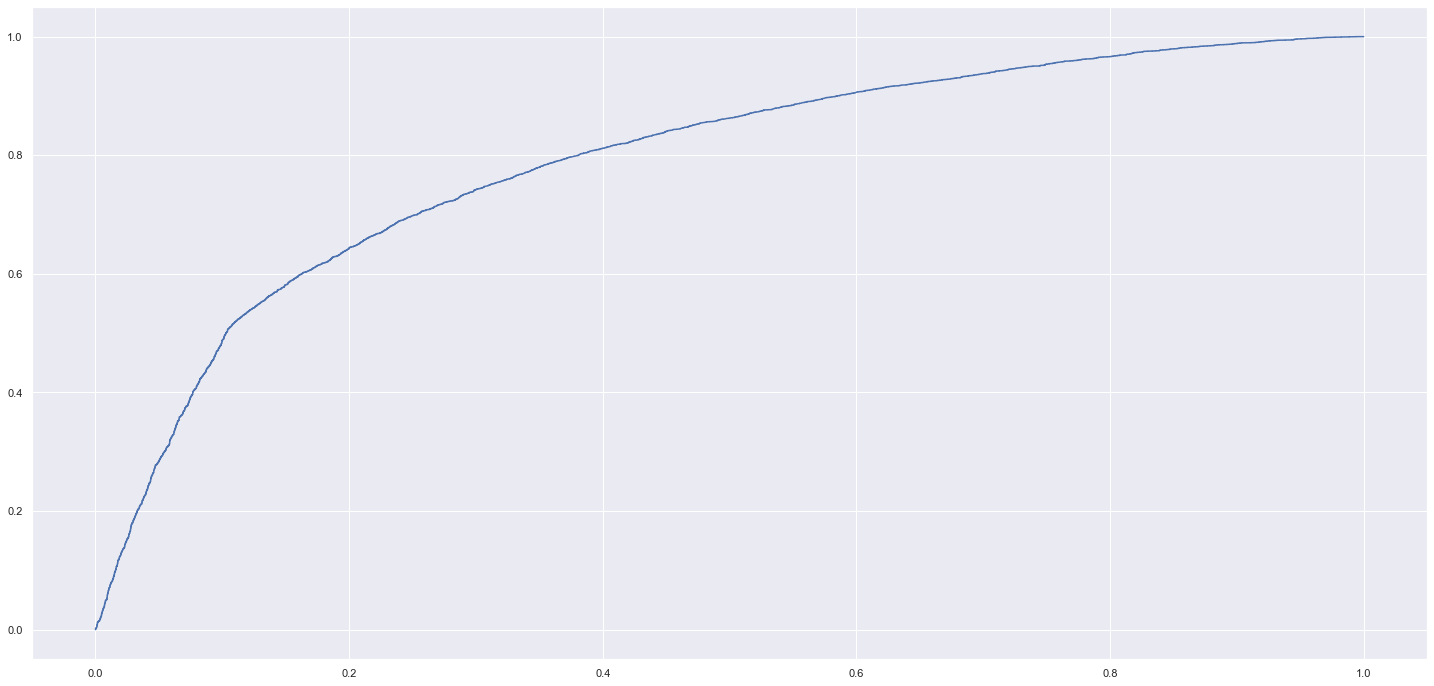

In [159]:
#AUC-ROC curve
probs = xgb_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = mt.roc_curve(y_test, preds)
plt.plot(fpr, tpr, 'b', label = 'AUC-ROC curve')

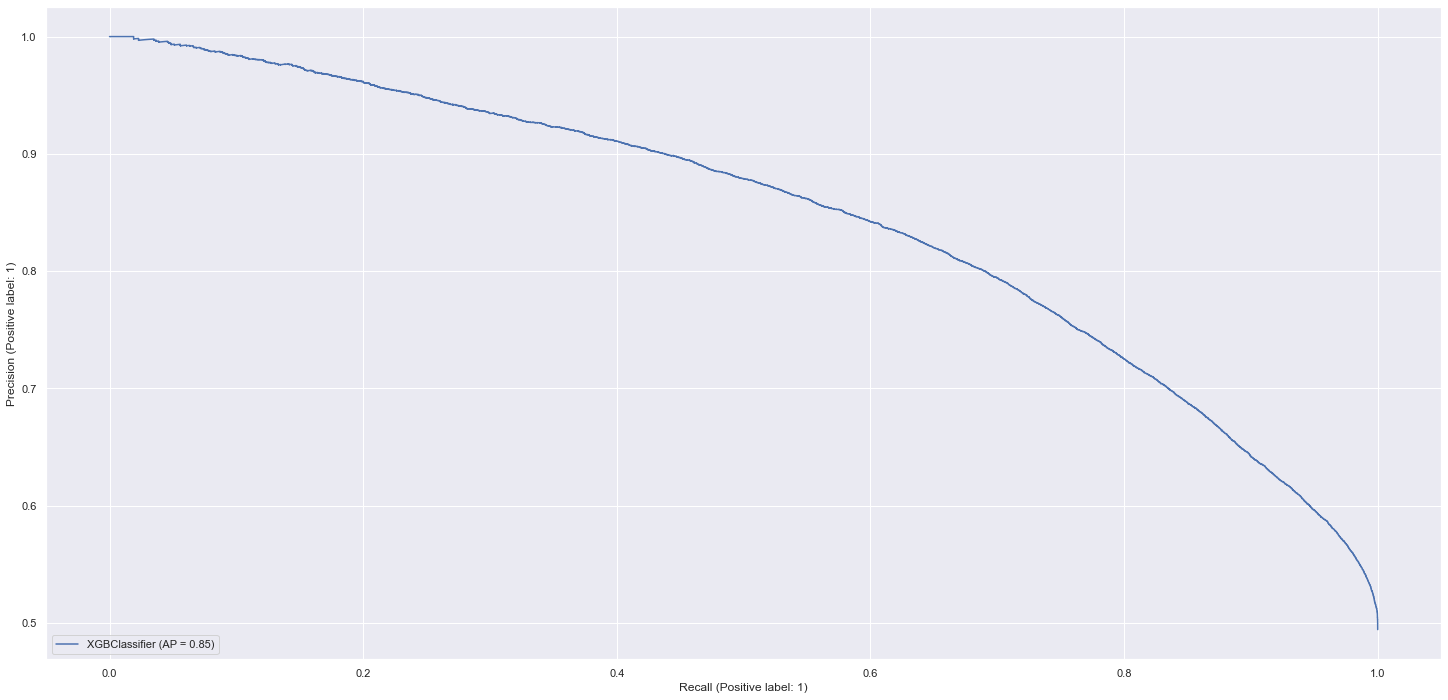

In [158]:
#precision_recall_curve
plot_precision_recall_curve(xgb_model, X_train, y_train)

### 7.3.1. XGBoost Classifier - Cross-Validation

In [160]:
#cross validation scores
xgb_cv = cross_val_score(xgb_model,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(xgb_cv),4),np.round(np.std(xgb_cv),4)))

Average: 0.7298 +/- Std 0.0074


## 7.4. LGBM Classifier

In [161]:
#define model
model_lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

#training model
model_lgbm.fit(X_train, y_train)

#predict model
yhat_lgbm = model_lgbm.predict(X_test)

# AUC-ROC
lgbm_cv = cross_val_predict(model_lgbm, X_train, y_train, cv=5)
lgbm_roc = roc_auc_score(y_train, lgbm_cv)


#performance
result_lgbm = pd.DataFrame(["LGBM Classifier",accuracy_score(y_test,yhat_lgbm),cohen_kappa_score(y_test,yhat_lgbm),
                          recall_score(y_test,yhat_lgbm), f1_score(y_test,yhat_lgbm),lgbm_roc,
                           precision_score(y_test,yhat_lgbm)]).T
result_lgbm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","roc_auc_score","Precision_score"]
print(result_lgbm)

#classification_report
print(classification_report(y_test, yhat_lgbm))

#confusion_matrix
print("Confusion matrix:")
print(mt.confusion_matrix(y_test,yhat_lgbm))

             Model  Accuracy Kappa Score    Recall  F1-Score roc_auc_score  \
0  LGBM Classifier  0.730067     0.45951  0.679315  0.713389      0.731796   

  Precision_score  
0        0.751061  
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6923
           1       0.75      0.68      0.71      6773

    accuracy                           0.73     13696
   macro avg       0.73      0.73      0.73     13696
weighted avg       0.73      0.73      0.73     13696

Confusion matrix:
[[5398 1525]
 [2172 4601]]


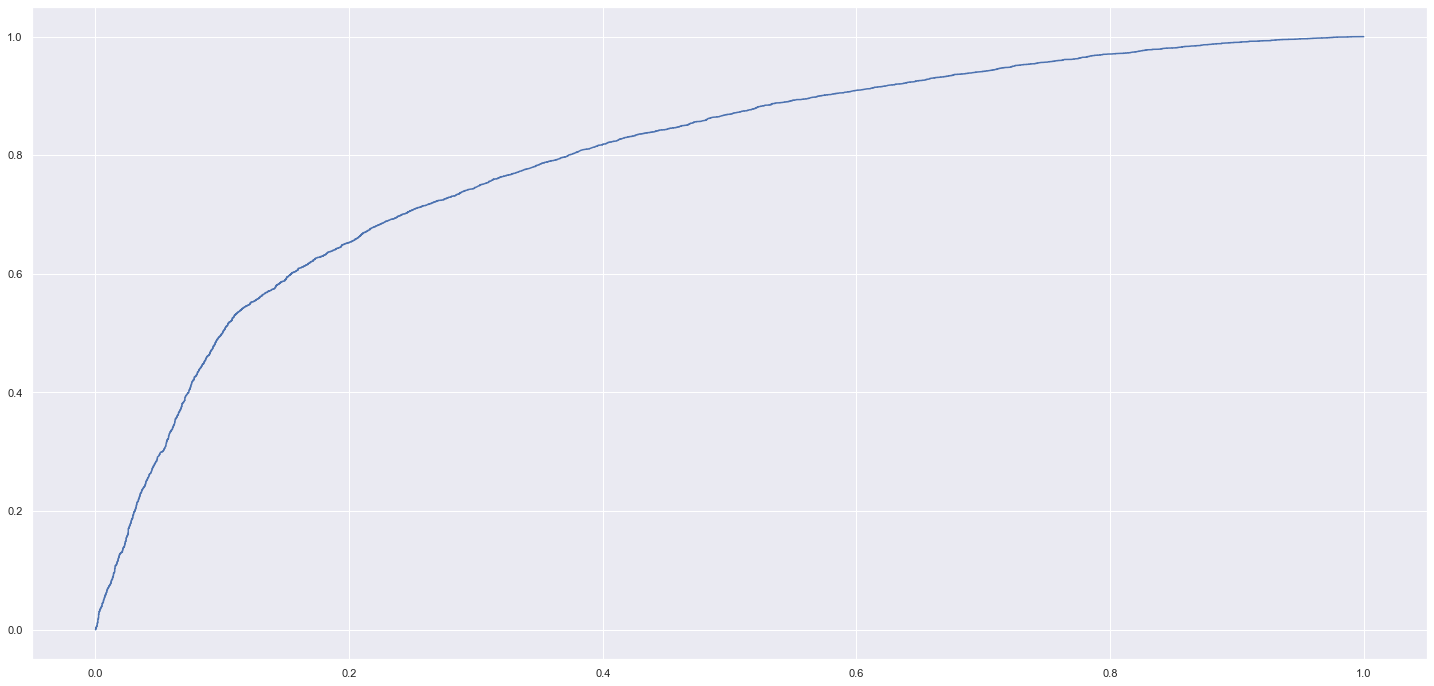

In [162]:
#AUC-ROC curve
probs = model_lgbm.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = mt.roc_curve(y_test, preds)
plt.plot(fpr, tpr, 'b', label = 'AUC-ROC curve')

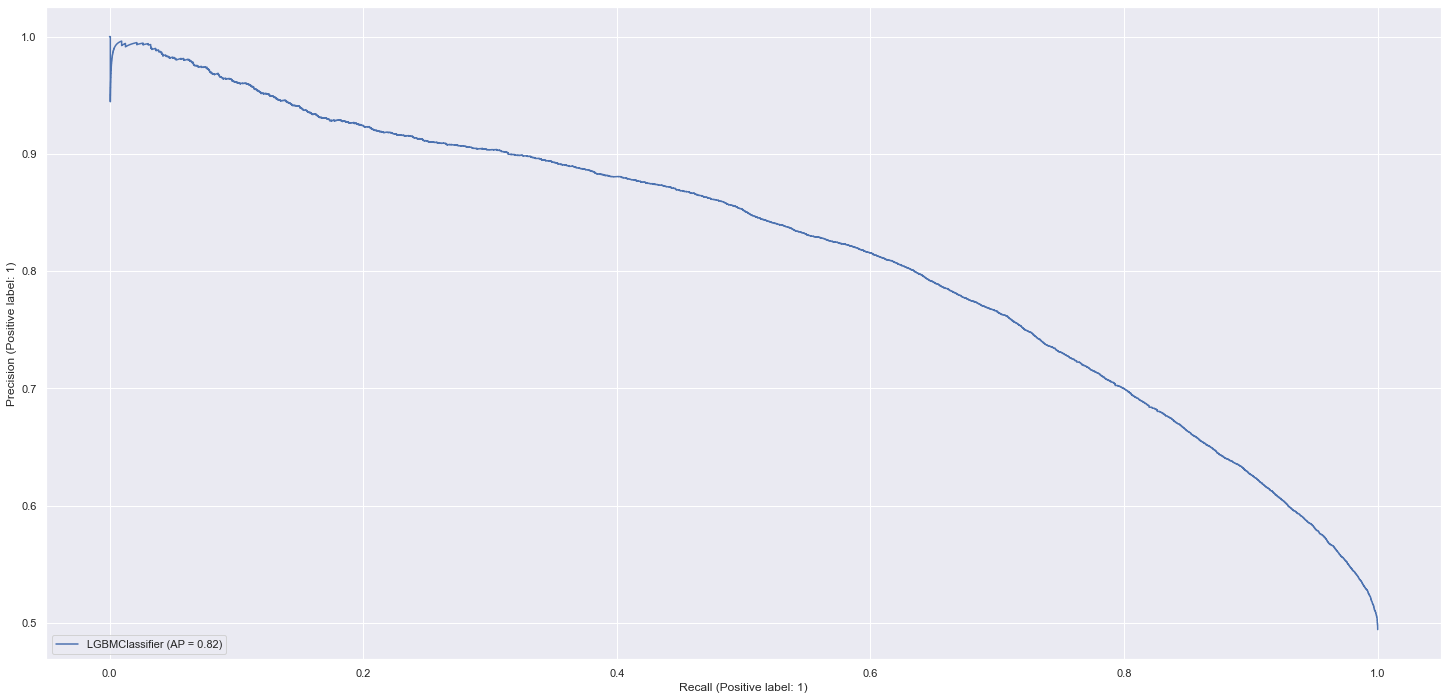

In [163]:
#precision_recall_curve
plot_precision_recall_curve(model_lgbm, X_train, y_train)

### 7.4.1. LGBM - Cross-Validation

In [164]:
#cross validation scores
lgbm_cv = cross_val_score(model_lgbm,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(lgbm_cv),4),np.round(np.std(lgbm_cv),4)))

Average: 0.732 +/- Std 0.0072


## 7.5. Performance Machine Learning Model

### 7.5.1. Summary Metrics

In [165]:
#concat all the models as a dataframe
result_model = pd.concat([result_xgb,result_knn,result_lgbm,result_rf])
result_model.sort_values("Accuracy", ascending = False)

,Model,Accuracy,Kappa Score,Recall,F1-Score,roc_auc_score,Precision_score
0,LGBM Classifier,0.730067,0.45951,0.679315,0.713389,0.731796,0.751061
0,XGBoost Classifier,0.723423,0.446239,0.675329,0.707174,0.728262,0.742171
0,Random Forest Classifier,0.70663,0.412984,0.687288,0.698529,0.703409,0.710145
0,KNearestNeighbors,0.674577,0.348751,0.648014,0.663241,0.667849,0.679201


In [167]:
accuracy = pd.DataFrame([np.mean(xgb_cv),np.mean(knn_cv),np.mean(lgbm_cv),np.mean(rf_cv)])
std = pd.DataFrame([np.std(xgb_cv),np.std(knn_cv),np.std(lgbm_cv),np.std(rf_cv)])
models = pd.DataFrame(["XGBoost Classifier", "KNearest Neighbors","LGBM Classifier","Random Forest Classifier"])
colunas = ['Modelo']

models.columns = colunas
models['Accuracy'] = accuracy
models['Standard Deviation'] = std

models

,Modelo,Accuracy,Standard Deviation
0,XGBoost Classifier,0.729828,0.007424
1,KNearest Neighbors,0.470281,0.499116
2,LGBM Classifier,0.731982,0.007161
3,Random Forest Classifier,0.703231,0.004301


### 7.8.2. Roc-curve

LGBM: ROC AUC=0.795
XGBoostClassifier: ROC AUC=0.789
KNearestNeighbors: ROC AUC=0.714
RandomForestClassifier: ROC AUC=0.765


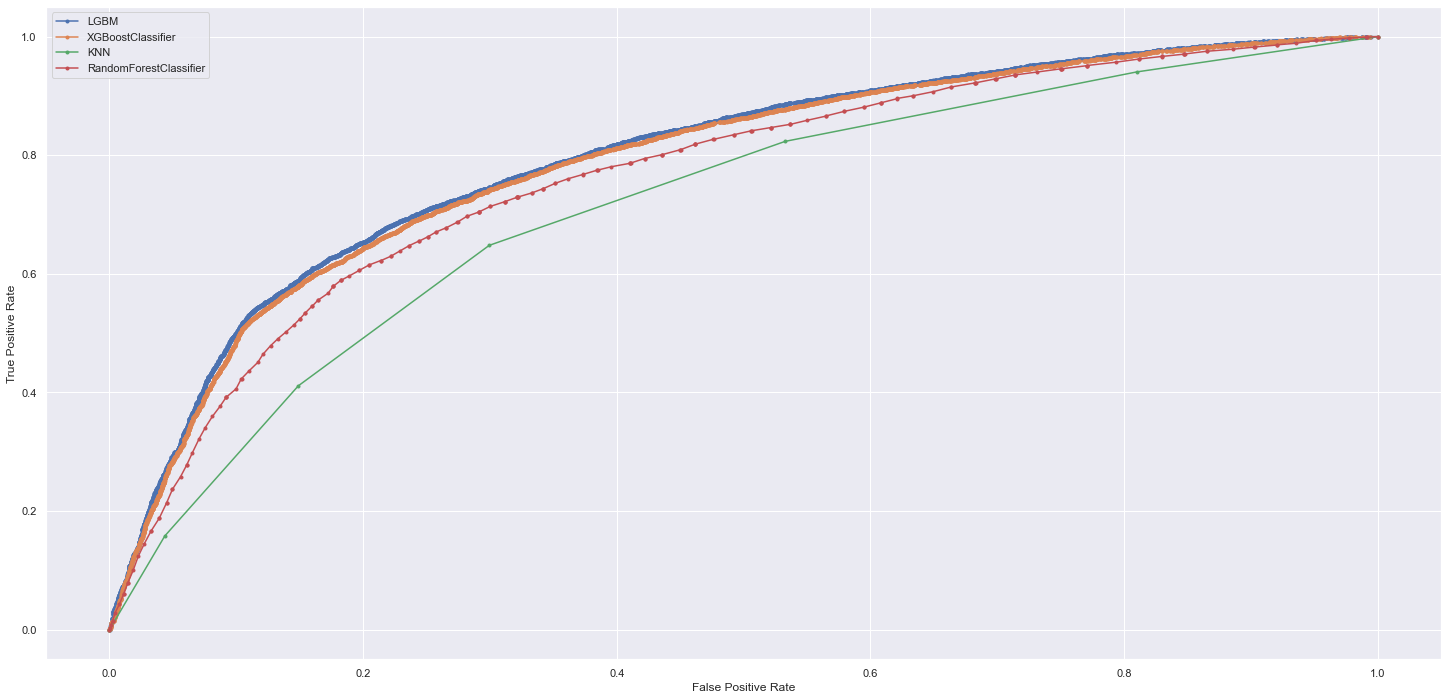

In [168]:
#machine leraning model
lgbm_probs = model_lgbm.predict_proba(X_test)
xgb_probs = xgb_model.predict_proba(X_test)
knn_probs = knn.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)


# keep probabilities for the positive outcome only
lgbm_probs = lgbm_probs[:,1]
xgb_probs = xgb_probs[:,1]
knn_probs = knn_probs[:,1]
rf_probs = rf_probs[:,1]

# calculate scores
lgbm_auc = roc_auc_score(y_test, lgbm_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

# summarize scores
print('LGBM: ROC AUC=%.3f' % (lgbm_auc))
print('XGBoostClassifier: ROC AUC=%.3f' % (xgb_auc))
print('KNearestNeighbors: ROC AUC=%.3f' % (knn_auc))
print('RandomForestClassifier: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

#plot
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoostClassifier')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RandomForestClassifier')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# 8.0. HYPERPARAMETER FINE TUNNING

## 8.1. Random Search CV

In [96]:
#define model
model_lgbm = LGBMClassifier(n_jobs = -1, random_state = 42)

#parameters
parameters = {'max_depth': np.arange(2, 12, 2), 
         'num_leaves': 2 ** np.arange(2, 10, 2),
         'min_data_in_leaf': np.arange(100, 1050, 50), 
         'learning_rate': np.linspace(0.001, 0.6, 15),
         'colsample_bytree': np.linspace(0.1, 1, 5),
         'subsample': np.linspace(0.25, 1, 15),
         'n_estimators': np.arange(10, 105, 15)}

#define RandomSearchCV
lgbm_random_cv = RandomizedSearchCV(estimator=model_lgbm, param_distributions=parameters,
                                scoring='accuracy', n_iter=100, cv=10, verbose=2,
                                random_state=42, n_jobs=-1)

#fit RandomSearchCV
lgbm_random_cv.fit(X_train, np.ravel(y_train))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=LGBMClassifier(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'learning_rate': array([0.001     , 0.04378571, 0.08657143, 0.12935714, 0.17214286,
       0.21492857, 0.25771429, 0.3005    , 0.34328571, 0.38607143,
       0.42885714, 0.47164286, 0.51442857, 0.55721429, 0.6       ]),
                                        'max_depth': arr...
                                        'min_data_in_leaf': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000]),
                                        'n_estimators': array([ 10,  25,  40,  55,  70,  85, 100]),
                                        'num_leaves': array([  4,  16,  64, 256], dtype=int32),
                                        'subsample': array([0.25      , 0.30357143, 0.35714286, 0.41071429, 0.46428571,
       0.51785714, 0.57142857, 0.625     , 0.67857143, 0.73214286,
       0.78571429, 0.83928571, 0.89285714, 0.94642857, 1.        ])},
                   random_state=42, scoring='accuracy', verbose=2)

In [97]:
#get the best parameters to our model
lgbm_random_cv.best_estimator_

LGBMClassifier(colsample_bytree=0.55, learning_rate=0.17214285714285713,
               max_depth=4, min_data_in_leaf=750, num_leaves=256,
               random_state=42, subsample=0.7857142857142857)

## 8.2. Fit the model using the best parameters 

In [98]:
#define model
lgbm_hyper = LGBMClassifier(colsample_bytree=0.55, learning_rate=0.17214285714285713,
               max_depth=4, min_data_in_leaf=750, num_leaves=256,
               random_state=42, subsample=0.7857142857142857)

#fit model
lgbm_hyper.fit(X_train, y_train)

#predict model
yhat_lgbm_hyper = lgbm_hyper.predict(X_test)

#Performance
#performance
result_lgbm_hyper = pd.DataFrame(["LGBM Classifier",lgbm_random_cv.best_score_,accuracy_score(y_test,yhat_lgbm_hyper),cohen_kappa_score(y_test,yhat_lgbm_hyper),
                          recall_score(y_test,yhat_lgbm_hyper), f1_score(y_test,yhat_lgbm_hyper),lgbm_auc,
                           precision_score(y_test,yhat_lgbm_hyper)]).T
result_lgbm_hyper.columns = ["Model",'Best Score','Accuracy',"Kappa Score","Recall","F1-Score","ROC_AUC","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_lgbm_hyper))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6923
           1       0.75      0.68      0.71      6773

    accuracy                           0.73     13696
   macro avg       0.73      0.73      0.73     13696
weighted avg       0.73      0.73      0.73     13696



In [99]:
result_lgbm_hyper

,Model,Best Score,Accuracy,Kappa Score,Recall,F1-Score,ROC_AUC,Precision_score
0,LGBM Classifier,0.733607,0.728753,0.456924,0.681825,0.71315,0.795328,0.747491


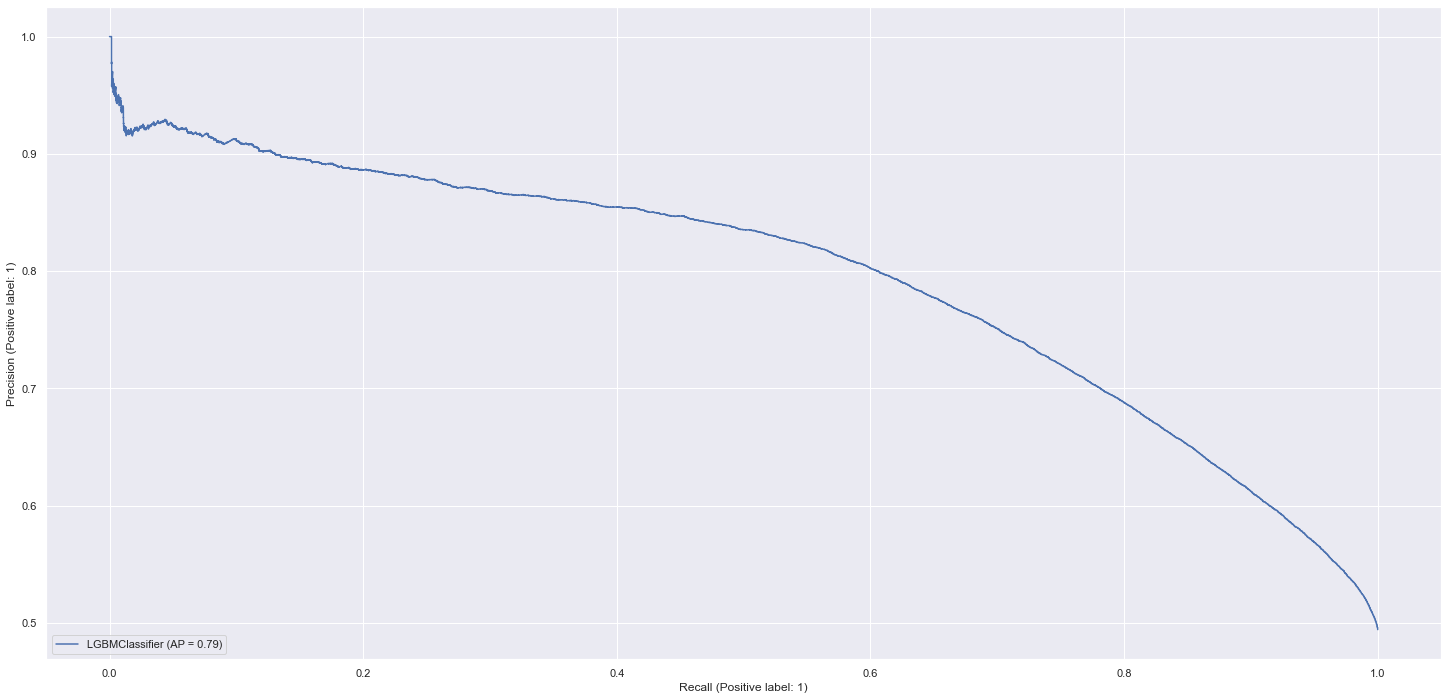

In [100]:
#confusion_matrix
mt.confusion_matrix(y_test,yhat_lgbm_hyper)

#precision_recall_curve
plot_precision_recall_curve(lgbm_hyper, X_train, y_train)

## 8.4. Real Performance - Cross-Validation 

In [105]:
#cross validation scores
lgbm_cv = cross_val_score(lgbm_hyper,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(lgbm_cv),4),np.round(np.std(lgbm_cv),4)))

Average: 0.7336 +/- Std 0.0079


# 9.0. BUSINESS PERFORMANCE

## 9.1. Accuracy and Precision

In [107]:
#results interpretation
result_lgbm_hyper

,Model,Best Score,Accuracy,Kappa Score,Recall,F1-Score,ROC_AUC,Precision_score
0,LGBM Classifier,0.733607,0.728753,0.456924,0.681825,0.71315,0.795328,0.747491


## 9.2. Confidence Interval

In [109]:
# binomial confidence interval
interval = 1.96 * sqrt( (0.2385 * (1 - 0.2385)) / X_test.shape[0])
print('%.3f' % interval)

conf_interval = ['Confidence Interval', "Worst Scenario", "Best Scenario"]
results = [interval, 0.2385 + interval, 0.2385 - interval]

conf = pd.DataFrame(results).T
conf.columns = conf_interval


0.007


## 9.3. Financial Return

In [110]:
#calculate financial feedback
business_perf = ['LGBM Classifier', "$ {:,.2f}".format(500*70000), "$ {:,.2f}".format(2500*len(df_raw)),"$ 140.000.000,00", "500%"]
df_business = pd.DataFrame(business_perf).T
df_business.columns = ["Model","Worst Scenario","Best Scenario","Gain","% Gain"]
df_business

,Model,Worst Scenario,Best Scenario,Gain,% Gain
0,LGBM Classifier,"$ 35,000,000.00","$ 175,000,000.00","$ 140.000.000,00",500%


# 10.0. DEPLOY MODEL TO PRODUCTION

## 10.1. Cardio Catch Diseases Class

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np

class Cardio(object):
    
    def __init__(self):
        
        self.scaler_ap_lo = pickle.load(open("/home/cecilia/repos/pa001_cardio_catch_diseases/parameter/rescaling_ap_lo.pkl","rb"))
        self.scaler_ap_hi = pickle.load(open("/home/cecilia/repos/pa001_cardio_catch_diseases/parameter/rescaling_ap_hi.pkl","rb"))
        self.scaler_weight = pickle.load(open("/home/cecilia/repos/pa001_cardio_catch_diseases/parameter/rescaling_weight.pkl","rb"))
        self.scaler_bmi = pickle.load(open("/home/cecilia/repos/pa001_cardio_catch_diseases/parameter/rescaling_bmi.pkl","rb"))
        self.scaler_age = pickle.load(open("/home/cecilia/repos/pa001_cardio_catch_diseases/parameter/rescaling_age_year.pkl","rb"))
        self.scaler_height = pickle.load(open("/home/cecilia/repos/pa001_cardio_catch_diseases/parameter/rescaling_height.pkl","rb"))

        
    def data_cleaning(self,df1):
    
        #coverting the age column to the years format
        df1['age_year'] = df1['age'].apply(lambda x: x/365)

        #age_year convert
        df1['age_year'] = df1['age_year'].astype(int)

        #changing id type to object
        df1['id'] = df1['id'].astype("object")
        
        return df1

    def feature_engineering(self, df2):

        #blood pressure
        df2['blood_pressure'] = df2.apply(lambda x:'normal' if (x['ap_hi'] <= 120) & (x['ap_lo'] <= 80)
                                         else 'elevated' if (x['ap_hi'] > 120 and x['ap_hi'] <= 129) & (x['ap_lo'] <= 80)
                                         else "high_blood_pressure" if (x['ap_hi'] >= 130 and x['ap_hi'] <= 139) & (x['ap_lo'] <= 90)
                                         else 'hypertension', axis = 1)

        #bmi calculation
        df2['bmi'] = round((df2['weight']/((df2['height'] * df2['height'])/10000)),2)

        #creating status_bmi 
        df2['status_bmi'] = df2['bmi'].apply(lambda x: 'underweight' if x <= 18.5
                                                  else 'normal' if (x > 18.5) & (x < 24.9) 
                                                  else 'overweight' if (x >= 25) & (x <= 29.9)
                                                  else 'obse' if (x >= 30) & (x<= 34.9) 
                                                  else 'extremely_obese')

        #creating age rage
        df2['age_range'] = df2['age_year'].apply(lambda x:"0-50" if x <= 50
                                                     else "50-65" if (x>50) & (x<=65)
                                                     else ">65")

        cols_drop = ['age','id']
        df2.drop(columns = cols_drop, axis = 1, inplace = True)

        #copying a new dataframe
        df2_clean = df2.copy() 

        #removing outliers
        df2_clean = df2_clean[~((df2_clean['ap_hi'] >= 220) | (df2_clean['ap_hi'] <= 90) 
                                | (df2_clean['ap_lo'] >= 150) | (df2_clean['ap_lo'] <= 65))]

        #filtering values
        df2_clean = df2_clean[(df2_clean['height'] > 140) & (df2_clean['height'] < 220)]
        
        df2 = df2_clean.copy()
        
        return df2

    def data_preparation(self, df5):        
        
        #blood_pressure - OrdinalEncoding
        dict_blood = {'normal':1, 'elevated':2,'high_blood_pressure':3, 'hypertension':4}
        df5['blood_pressure'] = df5['blood_pressure'].map(dict_blood)

        #status_bmi - OrdinalEncoding
        dict_bmi = {'underweight':1,'normal':2,'overweight':3,'obse':4,'extremely_obese':5}
        df5['status_bmi'] = df5['status_bmi'].map(dict_bmi)

        #age_range - OrdinalEncoding
        dict_age_range = {'50-65':2,'0-50':1}
        df5['age_range'] = df5['age_range'].map(dict_age_range)

        #gender - OneHotEncoding
        df5['gender_01'] = df5['gender'].apply(lambda x: 1 if x == 1 else 0)
        df5['gender_02'] = df5['gender'].apply(lambda x: 1 if x == 2 else 0 )    
        
        #ap_lo - RobustScaler
        df5['ap_lo'] = self.scaler_ap_lo.fit_transform(df5[['ap_lo']].values)

        #ap_hi - RobustScaler
        df5['ap_hi'] = self.scaler_ap_hi.fit_transform(df5[['ap_hi']].values)

        #weight - RobustScaler
        df5['weight'] = self.scaler_weight.fit_transform(df5[['weight']].values)

        #bmi - RobustScaler
        df5['bmi'] = self.scaler_bmi.fit_transform(df5[['bmi']].values)

        #age_year - MinMaxScaler
        df5['age_year'] = self.scaler_age.fit_transform(df5[['age_year']].values)

        #height - MinMaxScaler 
        df5['height'] = self.scaler_height.fit_transform(df5[['height']].values)

        #blood_pressure - OrdinalEncoding
        dict_blood = {'normal':1, 'elevated':2,'high_blood_pressure':3, 'hypertension':4}
        df5['blood_pressure'] = df5['blood_pressure'].map(dict_blood)

        #status_bmi - OrdinalEncoding
        dict_bmi = {'underweight':1,'normal':2,'overweight':3,'obse':4,'extremely_obese':5}
        df5['status_bmi'] = df5['status_bmi'].map(dict_bmi)

        #age_range - OrdinalEncoding
        dict_age_range = {'50-65':2,'0-50':1}
        df5['age_range'] = df5['age_range'].map(dict_age_range)

        #gender - OneHotEncoding
        df5['gender_01'] = df5['gender'].apply(lambda x: 1 if x == 1 else 0)
        df5['gender_02'] = df5['gender'].apply(lambda x: 1 if x == 2 else 0 )
        
        #features that will be really important to our model
        cols_selected = ['ap_hi','ap_lo','age_year','weight','height','blood_pressure','bmi','cholesterol']        
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient = 'records')

## 10.2. API Handler

In [ ]:
import pickle
from flask import Flask, request, Response
import pandas as pd
from cardio.Cardio import Cardio

model = pickle.load(open("/home/cecilia/repos/pa001_cardio_catch_diseases/model/model_cardio_lgbm.pkl", "rb"))

app = Flask(__name__)

@app.route("/cardio/predict", methods=['POST'])
def cardio_predict():
    print("Aqui")	
    test_json = request.get_json(force = True)
    print(test_json)
    
    if test_json:
        if isinstance(test_json,dict):           
            test_raw = pd.DataFrame(test_json, index = [0])
        else:
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
            
        pipeline = Cardio()
        print(test_raw.head())
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)        
        print("Aqui1")
        print(df1.head())

        
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        test_return = df2.copy()
        print("Aqui2")
        print(df2.head())

        
        #data preparation        
        df3 = pipeline.data_preparation(df2)
        print("Aqui3")
        print(df3.head())

        
        #prediction
        df_response = pipeline.get_prediction(model, test_return, df3)
        print("Aqui4")
        
        
        
        return df_response
                     
    else:
        return Response( "{}", status = 200, mimetype = "application/json")
    
if __name__ == "__main__":
    app.run("0.0.0.0", debug = True)

## 10.3. API Tester

In [13]:
import requests

In [ ]:
#loading test dataset
test_data = df_raw.sample(20)
test_data.drop("cardio", axis =1 , inplace = True)

#a = test_data.to_dict(orient='records')
#convert dataframe to json
#data = json.dumps(a)
data = test_data.to_json(orient='records')
type(data)

In [ ]:
data

In [ ]:
#API call
url = 'http://0.0.0.0:5000/cardio/predict'
header = {"Contet-type": 'application/json'}
data = data

#request
r = requests.post(url, data = data, headers = header)
print("Status Code {}".format(r.status_code))

In [ ]:
r.json()

In [ ]:
df = pd.DataFrame(r.json(), columns = r.json()[0].keys())
df